# Dataset paper pinn

In [8]:
# Download the dataset
!wget https://raw.githubusercontent.com/maziarraissi/PINNs/master/main/Data/cylinder_nektar_wake.mat -O ../data/cylinder/cylinder_nektar_wake.mat


--2025-09-11 15:40:01--  https://raw.githubusercontent.com/maziarraissi/PINNs/master/main/Data/cylinder_nektar_wake.mat
Resolviendo raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Conectando con raw.githubusercontent.com (raw.githubusercontent.com)[185.199.110.133]:443... 

conectado.
Petición HTTP enviada, esperando respuesta... 200 OK
Longitud: 24081984 (23M) [application/octet-stream]
Guardando como: ‘../data/cylinder/cylinder_nektar_wake.mat’

../data/cylinder/cy 100%[===================>]  22,97M  3,96MB/s    en 8,1s    

2025-09-11 15:40:10 (2,85 MB/s) - ‘../data/cylinder/cylinder_nektar_wake.mat’ guardado [24081984/24081984]



In [5]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt


data = loadmat("../data/cylinder/cylinder_nektar_wake.mat")

In [ ]:
data.keys(), data["X_star"].shape, data['p_star'].shape

(dict_keys(['__header__', '__version__', '__globals__', 'X_star', 't', 'U_star', 'p_star']),
 (5000, 2),
 (5000, 200))

In [6]:
np.unique(data["X_star"][:, 1]).shape

(50,)

(200, 50, 100)


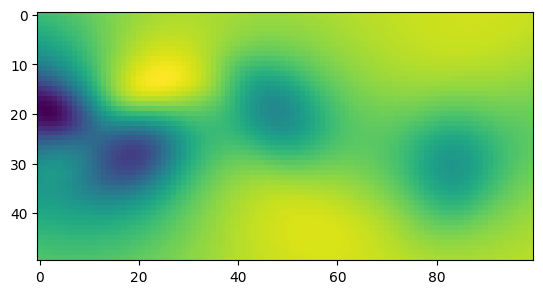

In [7]:
presiones = data['p_star'].reshape(50, 100, -1).transpose(2, 0, 1)
print(presiones.shape)
plt.imshow(presiones[0])
# plt.imshow(data['p_star'][:, 0].reshape(50, 100))

(64, 128)


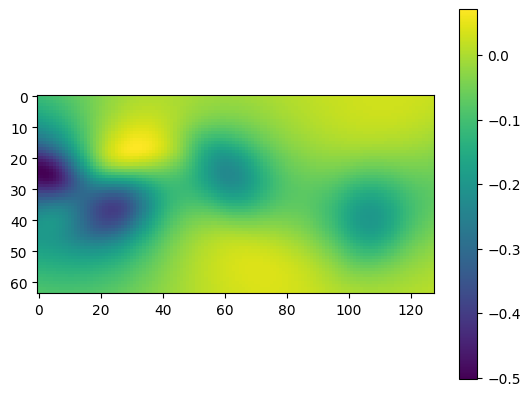

In [8]:
import numpy as np
from scipy.ndimage import zoom


# Calculate zoom factors
zoom_factors = (64/50, 128/100)  # (1.28, 1.28)

# Upsample using bilinear interpolation
upsampled = zoom(presiones[0], zoom_factors, order=1)
print(upsampled.shape)  # Should be (64, 128)
im = plt.imshow(upsampled)
plt.colorbar(im)

In [9]:
import matplotlib.animation as animation

fig, ax = plt.subplots()
im = ax.imshow(presiones[0], animated=True)
plt.colorbar(im)

def update(frame):
    im.set_array(presiones[frame])
    return [im]

ani = animation.FuncAnimation(fig, update, frames=presiones.shape[0], blit=True)
ani.save("presiones.gif", writer="pillow", fps=5)
plt.close(fig)

# Nvidia cylinder dataset

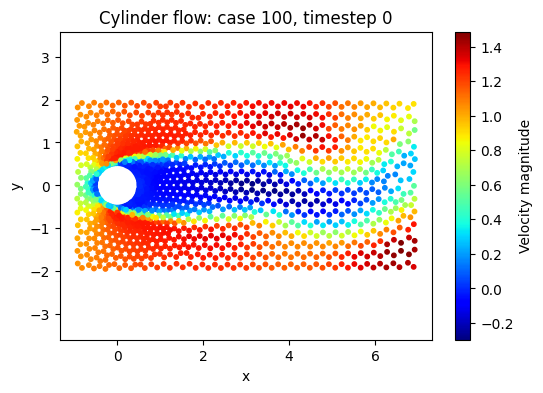

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Load dataset
data = np.load("dataset/rawData.npy", allow_pickle=True)#.item()

x = data['x']         # shape (time, case, nodes, vars)
coords = np.loadtxt("dataset/meshPosition_all.txt")  # shape (nodes, 2), columns [x,y]

# Choose one case and one time step
t_idx = 0       # first timestep
case_idx = 100    # first simulation
snapshot = x[t_idx, case_idx]  # shape (nodes, 3)

u = snapshot[:,0]   # x-velocity
v = snapshot[:,1]   # y-velocity
p = snapshot[:,2]   # pressure

# Plot velocity magnitude
vel_mag = np.sqrt(u**2 + v**2)

plt.figure(figsize=(6,4))
sc = plt.scatter(coords[:,0], coords[:,1], c=u, cmap="jet", s=10)
plt.colorbar(sc, label="Velocity magnitude")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Cylinder flow: case {}, timestep {}".format(case_idx, t_idx))
plt.axis("equal")
plt.show()


In [ ]:
import numpy as np
arr = np.load("dataset/rawData.npy", allow_pickle=True)

In [3]:
arr.keys(), arr["x"].shape

(dict_keys(['x', 'edge_attr', 'edge_index', 'mass', 'para']),
 (101, 401, 1699, 3))

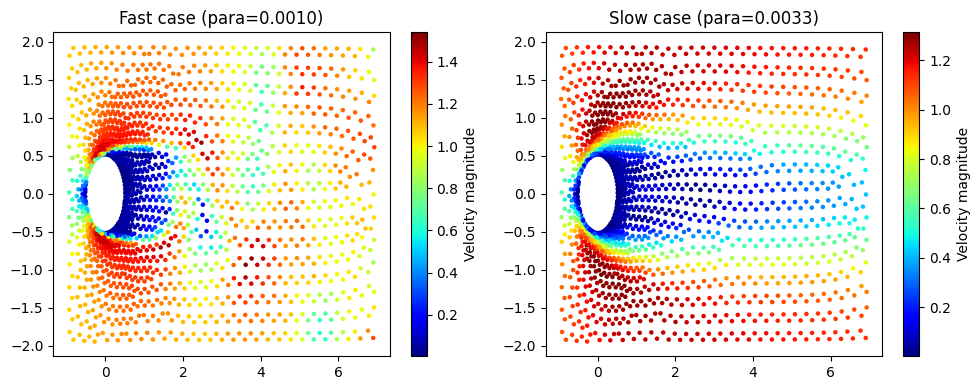

In [18]:
import numpy as np
import matplotlib.pyplot as plt

data = np.load("dataset/rawData.npy", allow_pickle=True)#.item()
coords = np.loadtxt("dataset/meshPosition_all.txt")
x = data['x']
para = data['para']

# Pick two cases: smallest vs largest parameter
case_fast = np.argmin(para)
case_slow = np.argmax(para)

# Take final timestep snapshot
t_idx = -1
snap_fast = x[t_idx, case_fast]
snap_slow = x[t_idx, case_slow]

u_fast, v_fast = snap_fast[:,0], snap_fast[:,1]
u_slow, v_slow = snap_slow[:,0], snap_slow[:,1]

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.scatter(coords[:,0], coords[:,1], c=np.sqrt(u_fast**2+v_fast**2), s=5, cmap="jet")
plt.colorbar(label="Velocity magnitude")
plt.title(f"Fast case (para={para[case_fast]:.4f})")

plt.subplot(1,2,2)
plt.scatter(coords[:,0], coords[:,1], c=np.sqrt(u_slow**2+v_slow**2), s=5, cmap="jet")
plt.colorbar(label="Velocity magnitude")
plt.title(f"Slow case (para={para[case_slow]:.4f})")

plt.tight_layout()
plt.show()


# CFDBench dataset

In [ ]:
from huggingface_hub import snapshot_download

# Download the whole CFDBench repo
dataset_path = snapshot_download(repo_id="chen-yingfa/CFDBench", repo_type="dataset", local_dir="../data/datasetCFDBench")

print("Dataset downloaded to:", dataset_path)


Fetching 8 files:   0%|          | 0/8 [00:00<?, ?it/s]

README.md:   0%|          | 0.00/807 [00:00<?, ?B/s]

.gitattributes: 0.00B [00:00, ?B/s]

bc.zip:   0%|          | 0.00/2.94G [00:00<?, ?B/s]

cavity.zip:   0%|          | 0.00/786M [00:00<?, ?B/s]

tube.zip:   0%|          | 0.00/213M [00:00<?, ?B/s]

geo.zip:   0%|          | 0.00/2.41G [00:00<?, ?B/s]

dam.zip:   0%|          | 0.00/1.35G [00:00<?, ?B/s]

prop.zip:   0%|          | 0.00/6.67G [00:00<?, ?B/s]

Dataset downloaded to: /home/d.ramos/pyLowOrder/datasetCFDBench


In [6]:
import numpy as np
import zipfile

# pick a case index
case_idx = "0000"

# open geo (geometry)
with zipfile.ZipFile("datasetCFDBench/cylinder/geo.zip") as z:
    # unzip the file
    z.extractall("datasetCFDBench/cylinder/geo")

# open bc (boundary conditions)
with zipfile.ZipFile("datasetCFDBench/cylinder/bc.zip") as z:
    z.extractall("datasetCFDBench/cylinder/bc")


# open prop (properties)
with zipfile.ZipFile("datasetCFDBench/cylinder/prop.zip") as z:
    z.extractall("datasetCFDBench/cylinder/prop")



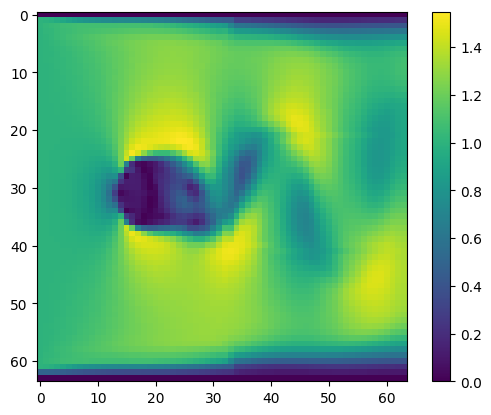

In [5]:
import numpy as np
import matplotlib.pyplot as plt

caso_ejemplo = "datasetCFDBench/cylinder/prop/case0060/u.npy"
u_ejemplo = np.load(caso_ejemplo)
im = plt.imshow(u_ejemplo[-1])
plt.colorbar(im)

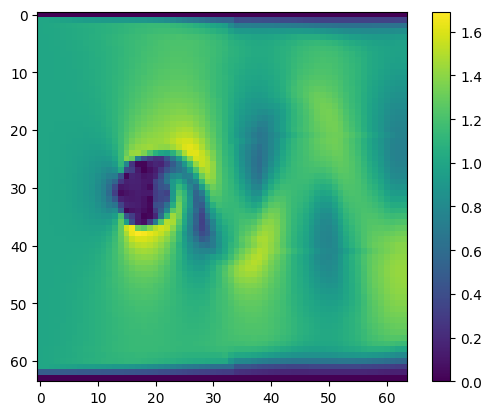

In [11]:
caso_ejemplo = "datasetCFDBench/cylinder/prop/case0070/u.npy"
u_ejemplo = np.load(caso_ejemplo)
im = plt.imshow(u_ejemplo[-1])
plt.colorbar(im)

In [14]:
import pandas as pd
from pathlib import Path

prop_dir = "datasetCFDBench/cylinder/prop/"

In [30]:
df = None
for file in Path(prop_dir).glob("case*/case.json"):
    if df is None:
        print("Reading first file:", file)
        df = pd.read_json(file, typ='series').to_frame().T
        continue
    json_data = pd.read_json(file, typ='series').to_frame().T
    df = pd.concat([df, json_data], ignore_index=True)


Reading first file: datasetCFDBench/cylinder/prop/case0050/case.json


In [31]:
df

vel_in  density  viscosity  radius  x_min  x_max  y_min  y_max
0       1.0      1.0     0.0010    0.01  -0.06   0.16  -0.06   0.06
1       1.0      2.0     0.0010    0.01  -0.06   0.16  -0.06   0.06
2       1.0      3.0     0.0010    0.01  -0.06   0.16  -0.06   0.06
3       1.0      4.0     0.0010    0.01  -0.06   0.16  -0.06   0.06
4       1.0      5.0     0.0010    0.01  -0.06   0.16  -0.06   0.06
..      ...      ...        ...     ...    ...    ...    ...    ...
111     1.0      6.0     0.0005    0.01  -0.06   0.16  -0.06   0.06
112     1.0      7.0     0.0005    0.01  -0.06   0.16  -0.06   0.06
113     1.0      8.0     0.0005    0.01  -0.06   0.16  -0.06   0.06
114     1.0      9.0     0.0005    0.01  -0.06   0.16  -0.06   0.06
115     1.0     10.0     0.0005    0.01  -0.06   0.16  -0.06   0.06

[116 rows x 8 columns]

In [34]:
df["density"].value_counts(), df["viscosity"].value_counts(), df["x_max"].value_counts()

(density
 1.0      4
 2.0      4
 3.0      4
 4.0      4
 5.0      4
 10.0     4
 6.0      3
 7.0      3
 8.0      3
 9.0      3
 50.0     3
 30.0     3
 40.0     3
 20.0     3
 11.0     2
 12.0     2
 13.0     2
 14.0     2
 15.0     2
 19.0     2
 18.0     2
 17.0     2
 16.0     2
 60.0     2
 70.0     2
 80.0     2
 90.0     2
 100.0    2
 0.7      2
 0.8      2
 0.5      2
 0.2      2
 0.3      2
 0.4      2
 0.9      2
 0.6      2
 0.1      2
 120.0    1
 110.0    1
 140.0    1
 150.0    1
 160.0    1
 130.0    1
 250.0    1
 240.0    1
 230.0    1
 220.0    1
 210.0    1
 200.0    1
 190.0    1
 180.0    1
 170.0    1
 400.0    1
 500.0    1
 300.0    1
 1.5      1
 2.5      1
 3.5      1
 4.5      1
 Name: count, dtype: int64,
 viscosity
 0.0050    28
 0.0100    28
 0.0010    23
 0.0005    19
 0.0001    18
 Name: count, dtype: int64,
 x_max
 0.16    116
 Name: count, dtype: int64)

# Dataset Laplace

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data_dir = "../data/laplace"

In [3]:
simulations = np.load(f"{data_dir}/laplace_dataset_solutions.npy")  # shape (num_simulations, height, width)
parameters = np.load(f"{data_dir}/laplace_dataset_parameters.npy")  # shape (num_simulations, 2)

In [4]:
# normalize the simulations to [0, 1]
sim_min = simulations.min(axis=(1,2), keepdims=True)
sim_max = simulations.max(axis=(1,2), keepdims=True)
simulations_norm = (simulations - sim_min) / (sim_max - sim_min)


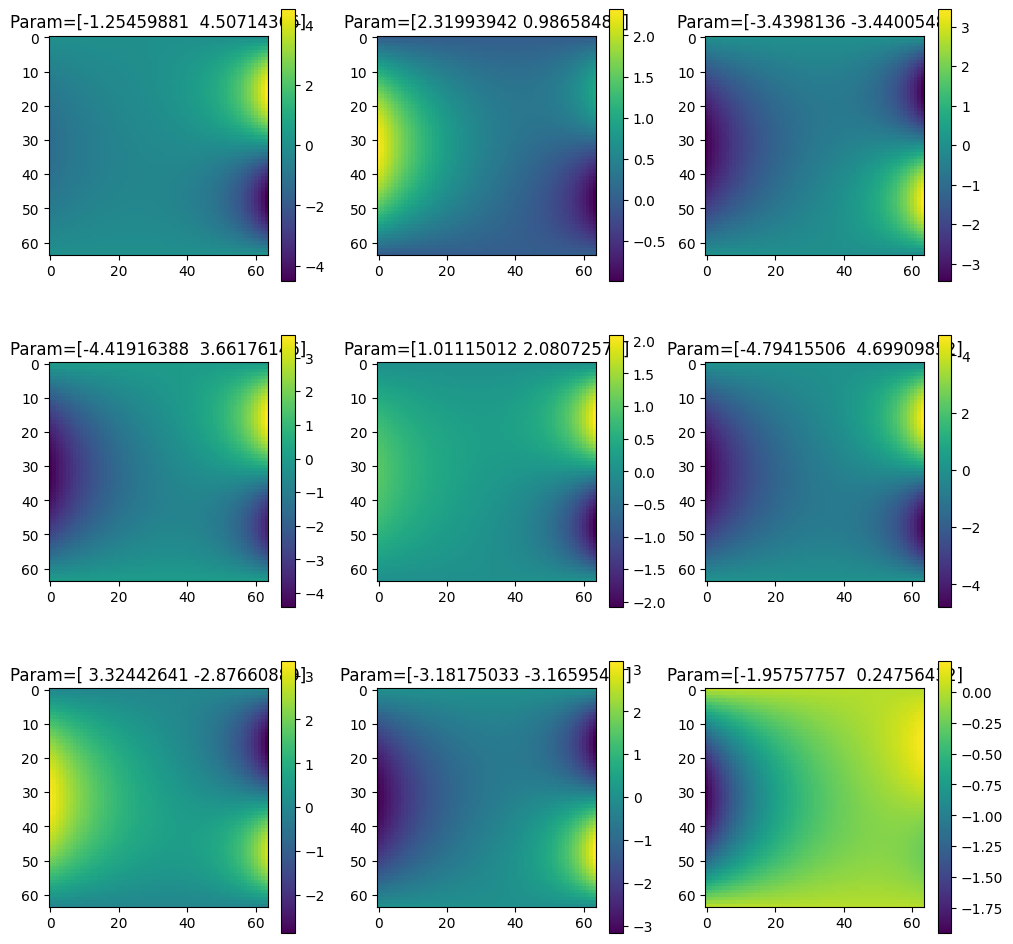

In [5]:
fig, axes = plt.subplots(3, 3, figsize=(12,12))

for i, ax in enumerate(axes.flat):
    im = ax.imshow(simulations[i])#, vmin=np.min(simulations), vmax=np.max(simulations))#, cmap="jet")
    ax.set_title(f"Param={parameters[i]}")
    plt.colorbar(im, ax=ax)



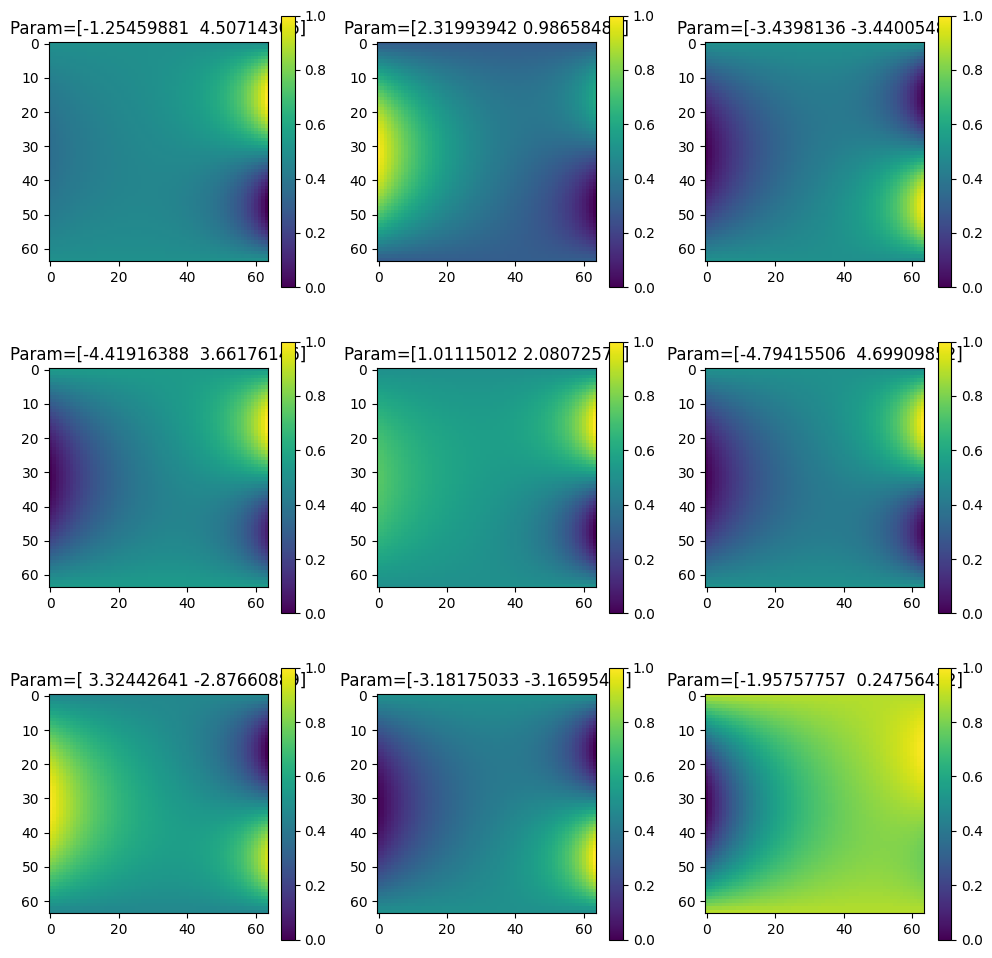

In [6]:
fig, axes = plt.subplots(3, 3, figsize=(12,12))

for i, ax in enumerate(axes.flat):
    im = ax.imshow(simulations_norm[i])
    ax.set_title(f"Param={parameters[i]}")
    plt.colorbar(im, ax=ax)

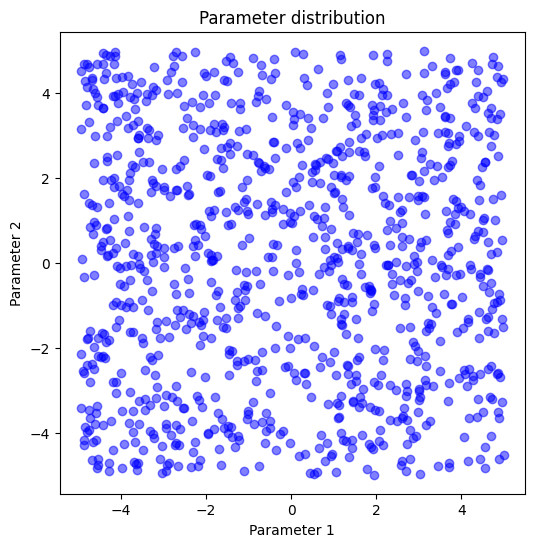

In [7]:
# scatter plot of parameters

plt.figure(figsize=(6,6))
plt.scatter(parameters[:,0], parameters[:,1], c='blue', alpha=0.5)
plt.xlabel("Parameter 1")
plt.ylabel("Parameter 2")
plt.title("Parameter distribution")
plt.axis("equal")
plt.show()

In [8]:
from generate_laplace_data import LaplaceDatasetGenerator
import matplotlib.pyplot as plt


In [9]:
generator = LaplaceDatasetGenerator(nx=64, ny=64, Lx=1.0, Ly=1.0)

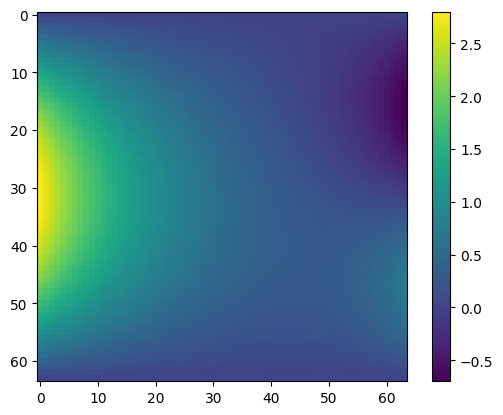

In [15]:
initial_alpha1, initial_alpha2 = 0.78, 0.43
min_alpha, max_alpha = -5, 5
scaled_alpha1 = initial_alpha1 * (max_alpha - min_alpha) + min_alpha
scaled_alpha2 = initial_alpha2 * (max_alpha - min_alpha) + min_alpha
solution, parameters = generator.solve_laplace(scaled_alpha1, scaled_alpha2)

def normalize_to_0_1(arr):
    arr_min = arr.min()
    arr_max = arr.max()
    return (arr - arr_min) / (arr_max - arr_min)

plt.imshow(solution)
plt.colorbar()

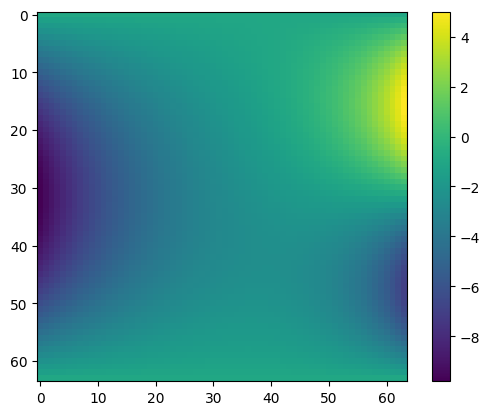

In [6]:
def normalize_to_neg_one_to_one(img):
    return img * 2 - 1

def unnormalize_to_zero_to_one(t):
    return (t + 1) * 0.5

norm = normalize_to_neg_one_to_one(solution)
sol = unnormalize_to_zero_to_one(norm)
plt.imshow(norm)
plt.colorbar()

# Dataset DLR

In [1]:
from netCDF4 import Dataset
import os
import numpy as np

In [2]:
fname = "../data/dlr_airfoils/test/Snap_Case0060_M0.63047_AoA1.64198"
nc_fid = Dataset(fname, 'r')
x = nc_fid.variables["x"][: 597]
z = nc_fid.variables["z"][: 597]
cp = nc_fid.variables["cp"][: 597]
mach = nc_fid.Mach
alpha = nc_fid.Alpha    

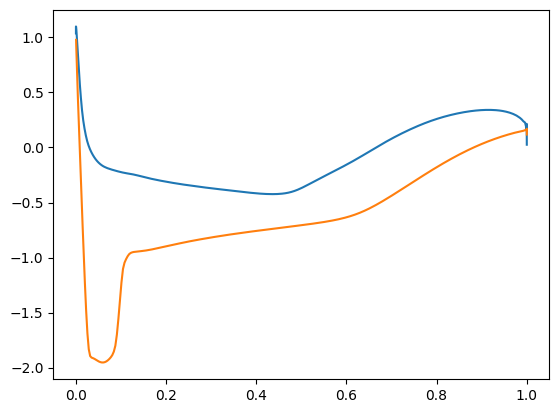

In [3]:
import matplotlib.pyplot as plt

plt.plot(x[:597//2], cp[:597//2])#, marker='.')
plt.plot(x[597//2:], cp[597//2:])#, marker='.', c='green')

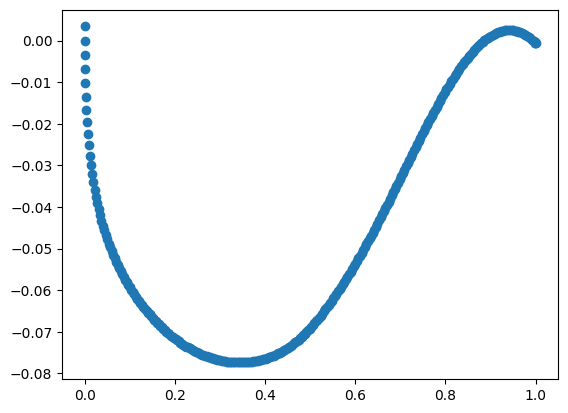

In [4]:
plt.scatter(x[:597//2], z[:597//2])
# plt.scatter(x[597//2:], z[597//2:])
# plt.scatter(x[298], z[298], marker='.')

In [5]:
x[297], z[297], x[298], z[298], x[299], z[299]

(1.0, -0.0005455, 1.0, -0.00036365, 1.0, -0.0001818)

In [6]:
x[:597//2].shape, x[597//2:].shape

((298,), (299,))

shape a tener en el dataset:  
(N_airfoils, 2, Num_puntos / 2)  
2 --> parte de arriba y parte de abajo  
Para la longitud de secuencia hay que tener en cuanta que el numero de puntos es impar, asi que hay que hacer algo ahi.

In [7]:
training_files = os.listdir("../data/dlr_airfoils/train/") 
training_files = list(map(lambda x: "../data/dlr_airfoils/train/" + x, training_files))
val_files = os.listdir("../data/dlr_airfoils/val/") 
val_files = list(map(lambda x: "../data/dlr_airfoils/val/" + x, val_files))
test_files = os.listdir("../data/dlr_airfoils/test")
test_files = list(map(lambda x: "../data/dlr_airfoils/test/" + x, test_files))
training_files = training_files #+ val_files
len(training_files), len(val_files), len(test_files)

(39, 20, 39)

In [8]:
def generate_arrays(files: list):
    airfoils, conditions = [], []
    for file_name in files:
        nc_fid = Dataset(file_name, 'r')
        cp = nc_fid.variables["cp"][: 597]
        mach = nc_fid.Mach
        alpha = nc_fid.Alpha
        cp_lower = cp[:298]
        cp_upper = cp[299:]
        conditions.append([mach, alpha])
        airfoils.append(np.vstack((cp_lower, cp_upper)))
        # print(np.vstack((cp_lower, cp_upper)).shape)
    
    airfoils = np.stack(airfoils, axis=0)
    conditions = np.array(conditions)

    return airfoils, conditions

In [9]:
airfoils_train, conditions_train = generate_arrays(training_files)
airfoils_train.shape, conditions_train.shape

((39, 2, 298), (39, 2))

In [10]:
np.save("../data/dlr_airfoils/cp_train_small", np.array(airfoils_train))
np.save("../data/dlr_airfoils/conditions_train_small", conditions_train)

In [46]:
airfoils_test, conditions_test = generate_arrays(test_files)
np.save("../data/dlr_airfoils/cp_test", np.array(airfoils_test))
np.save("../data/dlr_airfoils/conditions_test", conditions_test)

## See the predictions of the model

In [16]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset

In [17]:
data = np.load("../data/dlr_airfoils/cp_train.npy")
# at the moment the model expects inputs in [0, 1], like grayscale images 
data_min, data_max = data.min(), data.max()
data = (data - data_min) / (data_max - data_min)

In [30]:
preds = torch.load("../results/dlr_small/test_predictions.pt", weights_only=True)
preds = preds.view(-1, 2, 298)
true_values = np.load("../data/dlr_airfoils/cp_test.npy")#.flatten()
true_values = (true_values - data_min) / (data_max - data_min) 
parameters = np.load("../data/dlr_airfoils/conditions_test.npy")

In [31]:
preds.shape, true_values.shape

(torch.Size([39, 2, 298]), (39, 2, 298))

In [32]:
((preds - true_values) ** 2).mean(), np.abs(preds - true_values).mean()

(tensor(0.0002, dtype=torch.float64), tensor(0.0055, dtype=torch.float64))

In [27]:
fname = "../data/dlr_airfoils/test/Snap_Case0060_M0.63047_AoA1.64198"
nc_fid = Dataset(fname, 'r')
x = nc_fid.variables["x"][: 597]
x_lower = x[:298]
x_upper = x[299:]
x = np.concatenate((x_lower, x_upper))

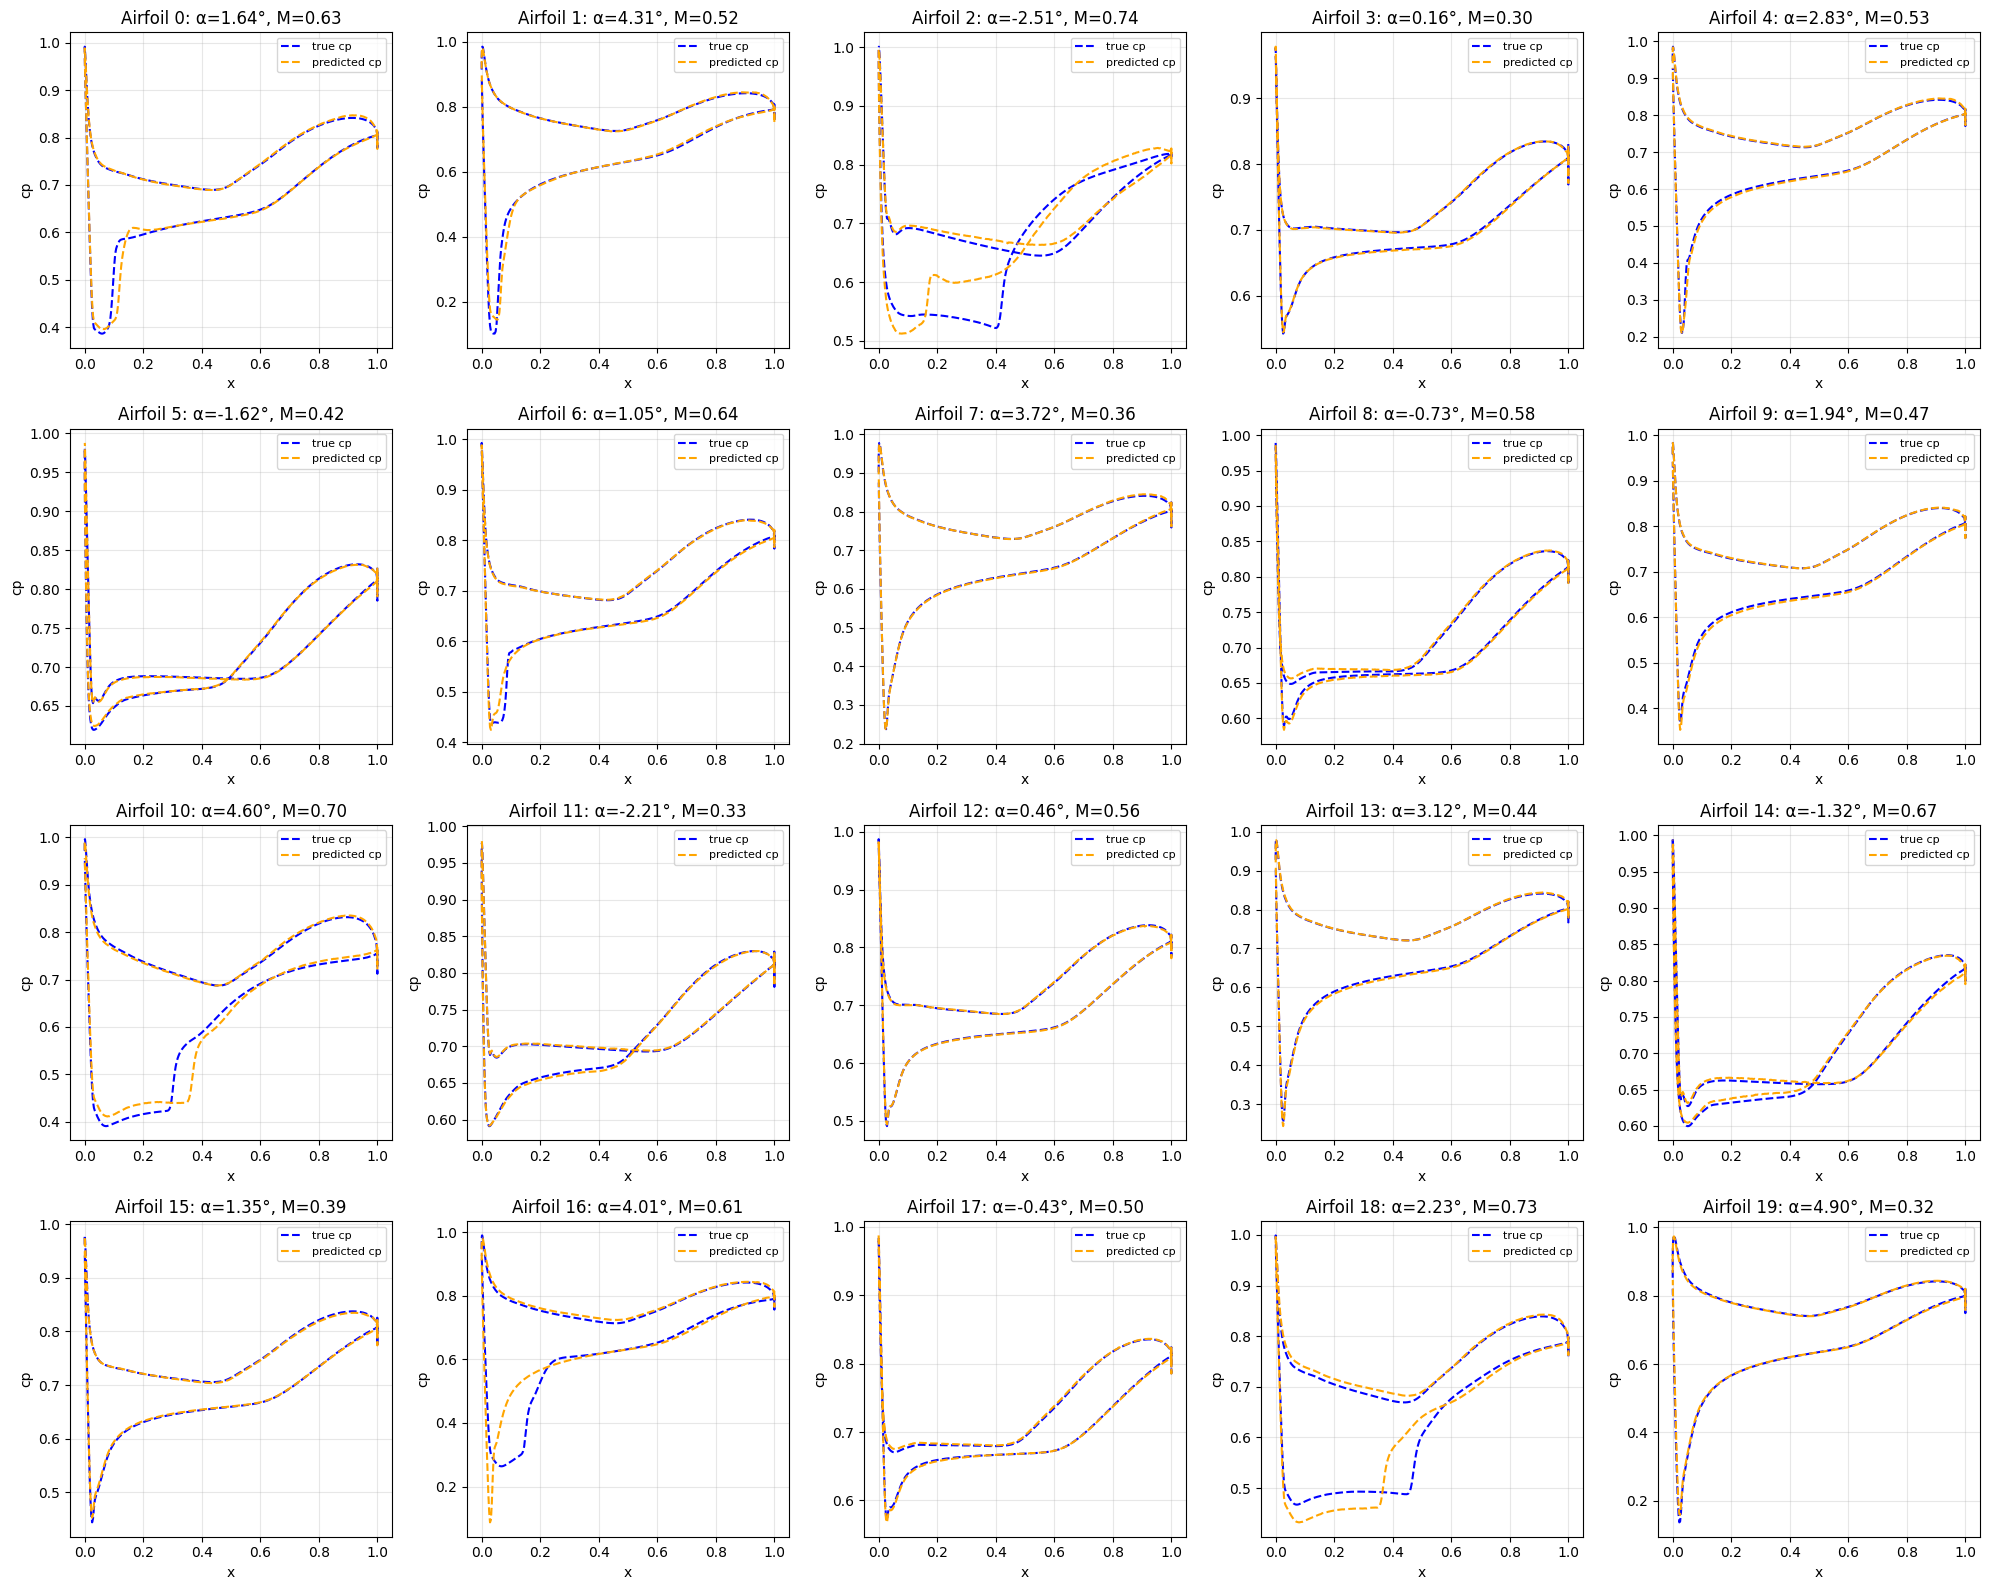

In [28]:
POINTS_PER_AIRFOIL = 298 * 2

# Create a 4x5 grid for 20 airfoils
fig, axes = plt.subplots(4, 5, figsize=(20, 16))
axes = axes.flatten()  # Flatten to make indexing easier

for airfoil_idx in range(20):
    ax = axes[airfoil_idx]
    # airfoil_idx += 19
    
    # Get data for current airfoil
    cp_pred = preds[airfoil_idx].flatten()
    cp_true = true_values[airfoil_idx].flatten()
    conditions = parameters[airfoil_idx]
    
    # Plot on current subplot
    ax.plot(x, cp_true, label="true cp", c='blue', linestyle='dashed')
    ax.plot(x, cp_pred, label="predicted cp", c='orange', linestyle='dashed')
    ax.set_title(f"Airfoil {airfoil_idx}: α={conditions[1]:.2f}°, M={conditions[0]:.2f}")
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    ax.set_xlabel('x')
    ax.set_ylabel('cp')

plt.tight_layout()
plt.show()

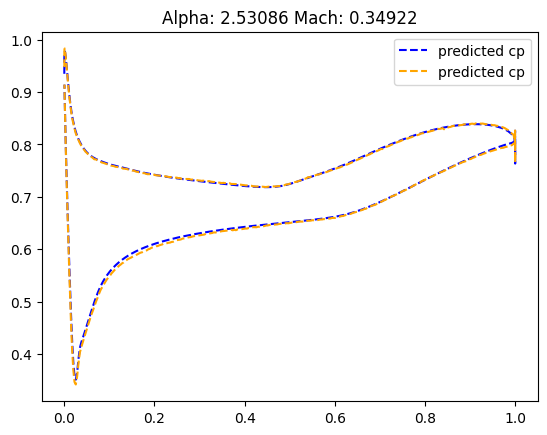

In [43]:
POINTS_PER_AIRFOIL = 298 * 2
airfoil_idx = 15
# cp_pred = preds[POINTS_PER_AIRFOIL*airfoil_idx:POINTS_PER_AIRFOIL*(airfoil_idx + 1)]
# cp_true = true_values[POINTS_PER_AIRFOIL*airfoil_idx:POINTS_PER_AIRFOIL*(airfoil_idx + 1)]
cp_pred = preds[airfoil_idx].flatten()
cp_true = true_values[airfoil_idx].flatten()
conditions = parameters[airfoil_idx]
# plt.scatter(x, cp_true, marker='.', label="true cp")
# plt.scatter(x, cp_pred, marker='.', label="predicted cp")
plt.plot(x, cp_true, label="predicted cp", c='blue', linestyle='dashed')
plt.plot(x, cp_pred, label="predicted cp", c='orange', linestyle='dashed')
plt.title(f"Alpha: {conditions[1]} Mach: {conditions[0]}")
plt.legend()

# Non-linear equation dataset

In [49]:
import numpy as np
import matplotlib.pyplot as plt

class AnalyticalFunctionDataset:
    def __init__(self, nx=64, ny=64, x_range=(0, 2*np.pi), y_range=(0, 2*np.pi)):
        """
        Initialize the analytical function dataset generator.
        
        Parameters:
        - nx, ny: Number of grid points in x and y directions
        - x_range, y_range: Domain ranges for x and y coordinates
        """
        self.nx = nx
        self.ny = ny
        self.x_range = x_range
        self.y_range = y_range
        
        # Create coordinate grids
        x = np.linspace(x_range[0], x_range[1], nx)
        y = np.linspace(y_range[0], y_range[1], ny)
        self.X, self.Y = np.meshgrid(x, y)
        
        print(f"Grid initialized: {nx}x{ny}")
        print(f"X domain: [{x_range[0]:.2f}, {x_range[1]:.2f}]")
        print(f"Y domain: [{y_range[0]:.2f}, {y_range[1]:.2f}]")
    
    def evaluate_function(self, alpha1, alpha2):
        """
        Evaluate a complex nonlinear function with chaotic behavior:
        f(x,y) = α₁*sin(α₂*x + y)*cos(x*y/α₁) + α₂*exp(-((x-π)² + (y-π)²)/(2*α₁²))*sin(α₁*x*y)
        
        Parameters:
        - alpha1, alpha2: Function parameters
        
        Returns:
        - result: 2D array with function values
        - parameters: dict with parameter values
        """
        # Avoid division by zero
        alpha1_safe = alpha1 if abs(alpha1) > 0.1 else 0.1 * np.sign(alpha1) if alpha1 != 0 else 0.1
        
        # Term 1: Coupled oscillations with frequency modulation
        term1 = alpha1 * np.sin(alpha2 * self.X + self.Y) * np.cos(self.X * self.Y / alpha1_safe)
        
        # Term 2: Gaussian-modulated nonlinear interaction
        gaussian = np.exp(-((self.X - np.pi)**2 + (self.Y - np.pi)**2) / (2 * alpha1_safe**2))
        term2 = alpha2 * gaussian * np.sin(alpha1 * self.X * self.Y / 5.0)  # Scale down the product to avoid extreme oscillations
        
        # Term 3: Add some chaos with a nonlinear combination
        term3 = 0.3 * np.tanh(alpha1 * np.sin(2*self.X) + alpha2 * np.cos(3*self.Y))
        
        # Term 4: Interference patterns
        term4 = 0.2 * alpha1 * alpha2 * np.sin(self.X + alpha2) * np.sin(self.Y + alpha1) / (1 + 0.1 * (self.X**2 + self.Y**2))
        
        result = term1 + term2 + term3 + term4
        
        parameters = {'alpha1': alpha1, 'alpha2': alpha2}
        
        return result, parameters
    
    def generate_dataset(self, n_samples, alpha1_range=(-2.0, 2.0), alpha2_range=(-2.0, 2.0), 
                        random_seed=42):
        """
        Generate a dataset of function evaluations.
        
        Parameters:
        - n_samples: Number of samples to generate
        - alpha1_range, alpha2_range: Ranges for parameter sampling
        - random_seed: Random seed for reproducibility
        
        Returns:
        - solutions: Array of shape (n_samples, ny, nx)
        - parameters: Array of shape (n_samples, 2) with [alpha1, alpha2]
        """
        np.random.seed(random_seed)
        
        solutions = []
        parameters = []
        
        print(f"Generating {n_samples} samples...")
        
        for i in range(n_samples):
            # Sample parameters uniformly
            alpha1 = np.random.uniform(*alpha1_range)
            alpha2 = np.random.uniform(*alpha2_range)
            
            # Evaluate function
            solution, params = self.evaluate_function(alpha1, alpha2)
            
            solutions.append(solution)
            parameters.append([alpha1, alpha2])
            
            if (i + 1) % 100 == 0:
                print(f"Generated {i + 1}/{n_samples} samples")
        
        solutions = np.array(solutions)
        parameters = np.array(parameters)
        
        print(f"Dataset generation complete!")
        
        return solutions, parameters
    
    def generate_grid_dataset(self, alpha1_values, alpha2_values):
        """
        Generate a dataset on a regular grid of parameter values.
        
        Parameters:
        - alpha1_values: Array of alpha1 values
        - alpha2_values: Array of alpha2 values
        
        Returns:
        - solutions: Array of shape (n_alpha1 * n_alpha2, ny, nx)
        - parameters: Array of shape (n_alpha1 * n_alpha2, 2)
        """
        solutions = []
        parameters = []
        
        total_samples = len(alpha1_values) * len(alpha2_values)
        print(f"Generating {total_samples} samples on regular grid...")
        
        count = 0
        for alpha1 in alpha1_values:
            for alpha2 in alpha2_values:
                solution, params = self.evaluate_function(alpha1, alpha2)
                solutions.append(solution)
                parameters.append([alpha1, alpha2])
                
                count += 1
                if count % 100 == 0:
                    print(f"Generated {count}/{total_samples} samples")
        
        solutions = np.array(solutions)
        parameters = np.array(parameters)
        
        return solutions, parameters
    
    def save_dataset(self, solutions, parameters, filename_prefix="analytical_dataset"):
        """Save the dataset to numpy files."""
        np.save(f"{filename_prefix}_solutions.npy", solutions)
        np.save(f"{filename_prefix}_parameters.npy", parameters)
        
        print(f"\nDataset saved as {filename_prefix}_solutions.npy and {filename_prefix}_parameters.npy")
        print(f"Solutions shape: {solutions.shape}")
        print(f"Parameters shape: {parameters.shape}")
        print(f"Solutions range: [{solutions.min():.4f}, {solutions.max():.4f}]")
    
    def visualize_samples(self, solutions, parameters, n_samples=9, figsize=(12, 10)):
        """Visualize some samples from the dataset."""
        n_samples = min(n_samples, len(solutions))
        indices = np.random.choice(len(solutions), n_samples, replace=False)
        
        rows = int(np.ceil(np.sqrt(n_samples)))
        cols = int(np.ceil(n_samples / rows))
        
        fig, axes = plt.subplots(rows, cols, figsize=figsize)
        if n_samples == 1:
            axes = [axes]
        else:
            axes = axes.ravel() if n_samples > 1 else axes
        
        for i, idx in enumerate(indices):
            if i >= len(axes):
                break
                
            # im = axes[i].contourf(self.X, self.Y, solutions[idx], levels=50, cmap='RdBu_r')
            im = axes[i].imshow(solutions[idx], cmap='RdBu_r')
            axes[i].set_title(f'α₁={parameters[idx][0]:.2f}, α₂={parameters[idx][1]:.2f}')
            axes[i].set_xlabel('x')
            axes[i].set_ylabel('y')
            axes[i].set_aspect('equal')
            plt.colorbar(im, ax=axes[i])
        
        # Hide empty subplots
        for i in range(len(indices), len(axes)):
            axes[i].set_visible(False)
        
        plt.tight_layout()
        plt.show()
    
    def analyze_dataset(self, solutions, parameters):
        """Analyze the generated dataset."""
        print("\n" + "="*50)
        print("DATASET ANALYSIS")
        print("="*50)
        
        print(f"Function: Complex nonlinear function with multiple interacting terms")
        print(f"f(x,y) = α₁*sin(α₂*x + y)*cos(x*y/α₁) + α₂*exp(-((x-π)² + (y-π)²)/(2*α₁²))*sin(α₁*x*y/5)")
        print(f"       + 0.3*tanh(α₁*sin(2x) + α₂*cos(3y)) + 0.2*α₁*α₂*sin(x+α₂)*sin(y+α₁)/(1+0.1*(x²+y²))")
        print(f"Number of samples: {len(solutions)}")
        print(f"Grid size: {self.nx} × {self.ny}")
        print(f"Domain: x ∈ [{self.x_range[0]:.2f}, {self.x_range[1]:.2f}], y ∈ [{self.y_range[0]:.2f}, {self.y_range[1]:.2f}]")
        
        print(f"\nParameter Statistics:")
        print(f"α₁: min={parameters[:, 0].min():.3f}, max={parameters[:, 0].max():.3f}, mean={parameters[:, 0].mean():.3f}")
        print(f"α₂: min={parameters[:, 1].min():.3f}, max={parameters[:, 1].max():.3f}, mean={parameters[:, 1].mean():.3f}")
        
        print(f"\nFunction Values:")
        print(f"f(x,y): min={solutions.min():.3f}, max={solutions.max():.3f}, mean={solutions.mean():.3f}")
        print(f"Standard deviation: {solutions.std():.3f}")
        
        # Theoretical maximum (when both sin and cos are at their peaks)
        max_alpha1 = max(abs(parameters[:, 0].min()), abs(parameters[:, 0].max()))
        max_alpha2 = max(abs(parameters[:, 1].min()), abs(parameters[:, 1].max()))
        theoretical_max = max_alpha1 * max_alpha2
        print(f"Theoretical maximum: ±{theoretical_max:.3f}")

Grid initialized: 64x64
X domain: [0.00, 6.28]
Y domain: [0.00, 6.28]

METHOD 1: Random Parameter Sampling
Generating 1000 samples...
Generated 100/1000 samples
Generated 200/1000 samples
Generated 300/1000 samples
Generated 400/1000 samples
Generated 500/1000 samples
Generated 600/1000 samples
Generated 700/1000 samples
Generated 800/1000 samples
Generated 900/1000 samples
Generated 1000/1000 samples
Dataset generation complete!

Dataset saved as non_linear_extrapolate_solutions.npy and non_linear_extrapolate_parameters.npy
Solutions shape: (757, 64, 64)
Parameters shape: (757, 2)
Solutions range: [-8.4624, 7.8078]

DATASET ANALYSIS
Function: Complex nonlinear function with multiple interacting terms
f(x,y) = α₁*sin(α₂*x + y)*cos(x*y/α₁) + α₂*exp(-((x-π)² + (y-π)²)/(2*α₁²))*sin(α₁*x*y/5)
       + 0.3*tanh(α₁*sin(2x) + α₂*cos(3y)) + 0.2*α₁*α₂*sin(x+α₂)*sin(y+α₁)/(1+0.1*(x²+y²))
Number of samples: 757
Grid size: 64 × 64
Domain: x ∈ [0.00, 6.28], y ∈ [0.00, 6.28]

Parameter Statistics:
α

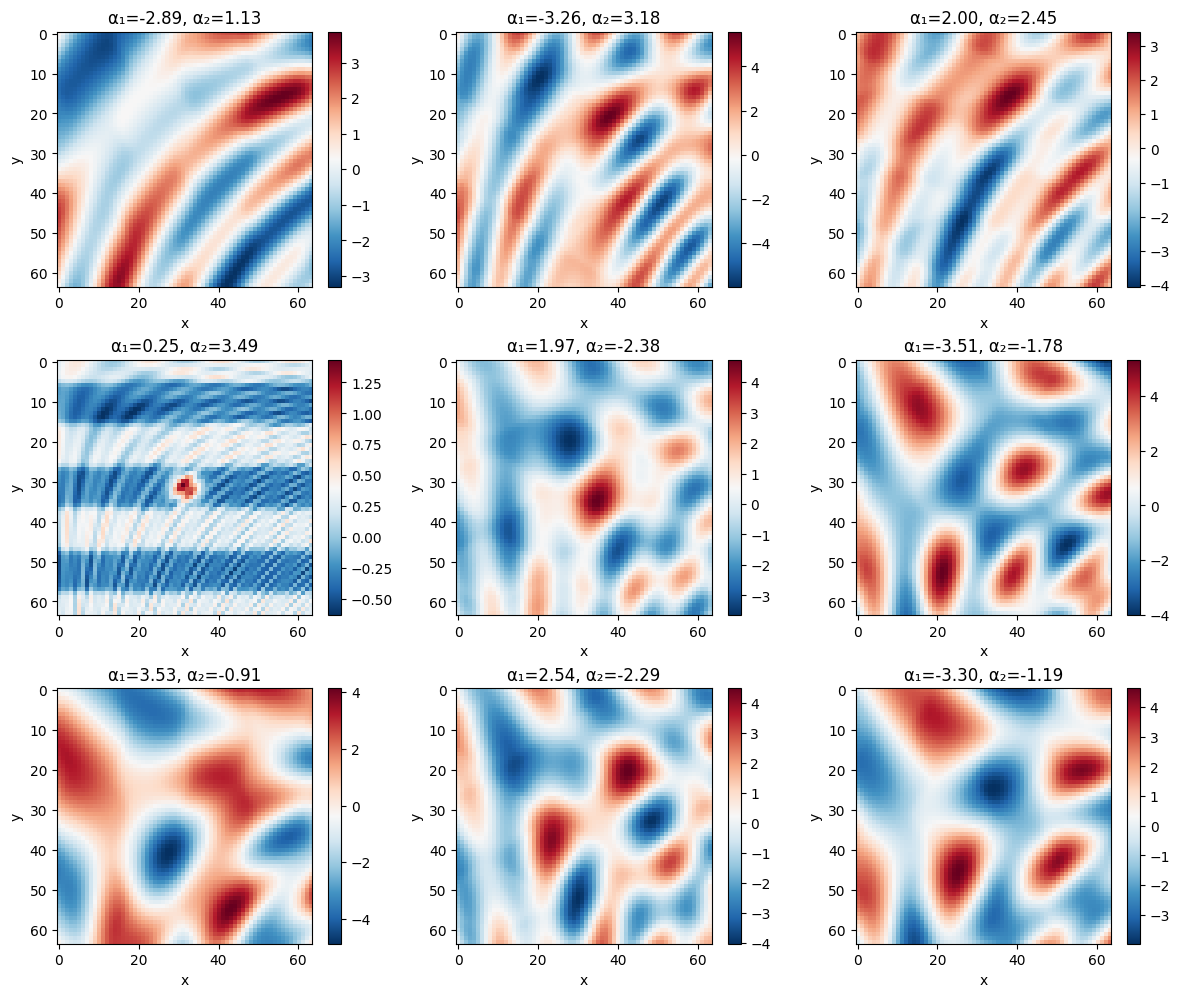

In [55]:
generator = AnalyticalFunctionDataset(nx=64, ny=64, x_range=(0, 2*np.pi), y_range=(0, 2*np.pi))
    
    # Method 1: Random sampling
print("\n" + "="*50)
print("METHOD 1: Random Parameter Sampling")
print("="*50)

solutions_random, parameters_random = generator.generate_dataset(
    n_samples=1000,
    alpha1_range=(-4.0, 4.0),
    alpha2_range=(-4.0, 4.0)
)
mask_train_area = (parameters_random[:, 0] <= 2) & (parameters_random[:, 0] >= -2) & (parameters_random[:, 1] <= 2) & (parameters_random[:, 1] >= -2)
solutions_random = solutions_random[~mask_train_area]
parameters_random = parameters_random[~mask_train_area]

# Save random dataset
generator.save_dataset(solutions_random, parameters_random, "non_linear_extrapolate")

# Analyze dataset
generator.analyze_dataset(solutions_random, parameters_random)

# Visualize samples
generator.visualize_samples(solutions_random, parameters_random, n_samples=9)

# Method 2: Grid sampling (optional)
# print("\n" + "="*50)
# print("METHOD 2: Regular Grid Sampling")
# print("="*50)

# alpha1_grid = np.linspace(-2, 2, 10)
# alpha2_grid = np.linspace(-2, 2, 10)

# solutions_grid, parameters_grid = generator.generate_grid_dataset(alpha1_grid, alpha2_grid)

# # Save grid datase
# generator.save_dataset(solutions_grid, parameters_grid, "analytical_grid")

# # Analyze grid dataset
# generator.analyze_dataset(solutions_grid, parameters_grid)

# print("\n" + "="*50)
# print("DATASETS READY FOR CNN TRAINING!")
# print("="*50)

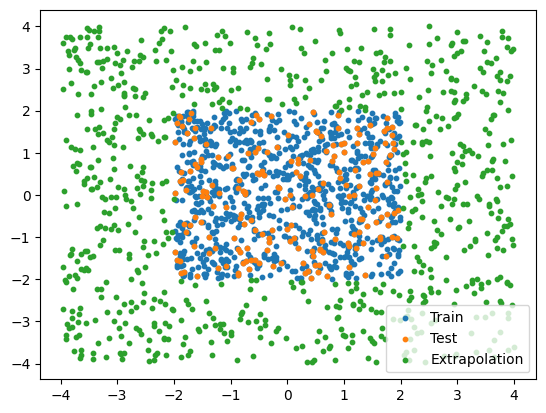

In [59]:
parameters_train = np.load("../data/non_linear_eq/non_linear_train_parameters.npy")
parameters_test = np.load("../data/non_linear_eq/non_linear_test_parameters.npy")
paramters_extrapolated = np.load("../data/non_linear_eq/non_linear_extrapolate_parameters.npy")

plt.scatter(parameters_train[:, 0], parameters_train[:, 1], label="Train", s=10)
plt.scatter(parameters_test[:, 0], parameters_test[:, 1], label="Test", s=10)
plt.scatter(paramters_extrapolated[:, 0], paramters_extrapolated[:, 1], label="Extrapolation", s=10)
plt.legend()
plt.show()

In [1]:
import torch 
import numpy as np
import matplotlib.pyplot as plt # RdBu_r

In [2]:
data = np.load("../data/non_linear_eq/non_linear_train_solutions.npy")
# at the moment the model expects inputs in [0, 1], like grayscale images 
data_min, data_max = data.min(), data.max()
data = (data - data_min) / (data_max - data_min)  # scale to [0, 1]
data = data[:, np.newaxis, :, :]  # add channel dimension   
parameters = np.load("../data/non_linear_eq/non_linear_train_parameters.npy")
# normalize parameters to [0, 1]
parameters_mean, parameters_std = parameters.mean(axis=0), parameters.std(axis=0)
parameters = (parameters - parameters_mean) / (parameters_std)

# load test data
test_data = np.load("../data/non_linear_eq/non_linear_test_solutions.npy")
test_data = (test_data - data_min) / (data_max - data_min) 
test_data = test_data[:, np.newaxis, :, :]
test_parameters = np.load("../data/non_linear_eq/non_linear_test_parameters.npy")
test_parameters = (test_parameters - parameters_mean) / (parameters_std)

In [3]:
predictions = torch.load("../results/non_linear_eq_big_128_bs/test_predictions.pt")

/tmp/ipykernel_1188036/4002862812.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  predictions = torch.load("../results/non_linear_eq_big_128_bs/test_predictions.pt")


In [9]:
def plot_images_grid(images, input_parameters):
    fig, axes = plt.subplots(int(np.sqrt(len(images))), int(np.sqrt(len(images))), figsize=(12,12))
    for i, ax in enumerate(axes.flat):
        im = ax.imshow(images[i].squeeze(), cmap="RdBu_r")
        ax.set_title(f"Alpha1={input_parameters[i][0].item():.2f}, Alpha2={input_parameters[i][1].item():.2f}")
        plt.colorbar(im, ax=ax)
        ax.axis('off')
    # plt.savefig(save_path, bbox_inches="tight", pad_inches=0)
    plt.plot()

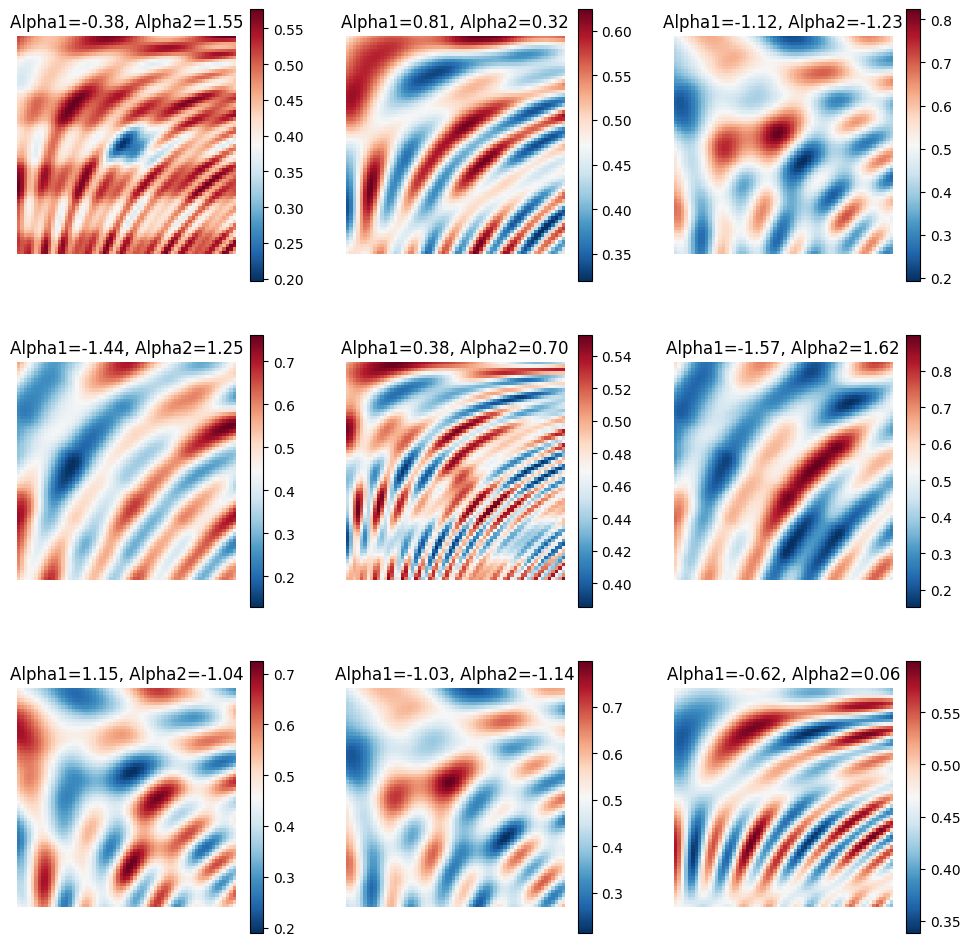

In [10]:
num_images = 9
inputs_to_plot = test_parameters[:num_images]
real_values_to_plot = test_data[:num_images]
plot_images_grid(
    real_values_to_plot,
    inputs_to_plot,
)

In [15]:
predictions = predictions.view(-1, 1, 64, 64)
predictions.shape

torch.Size([200, 1, 64, 64])

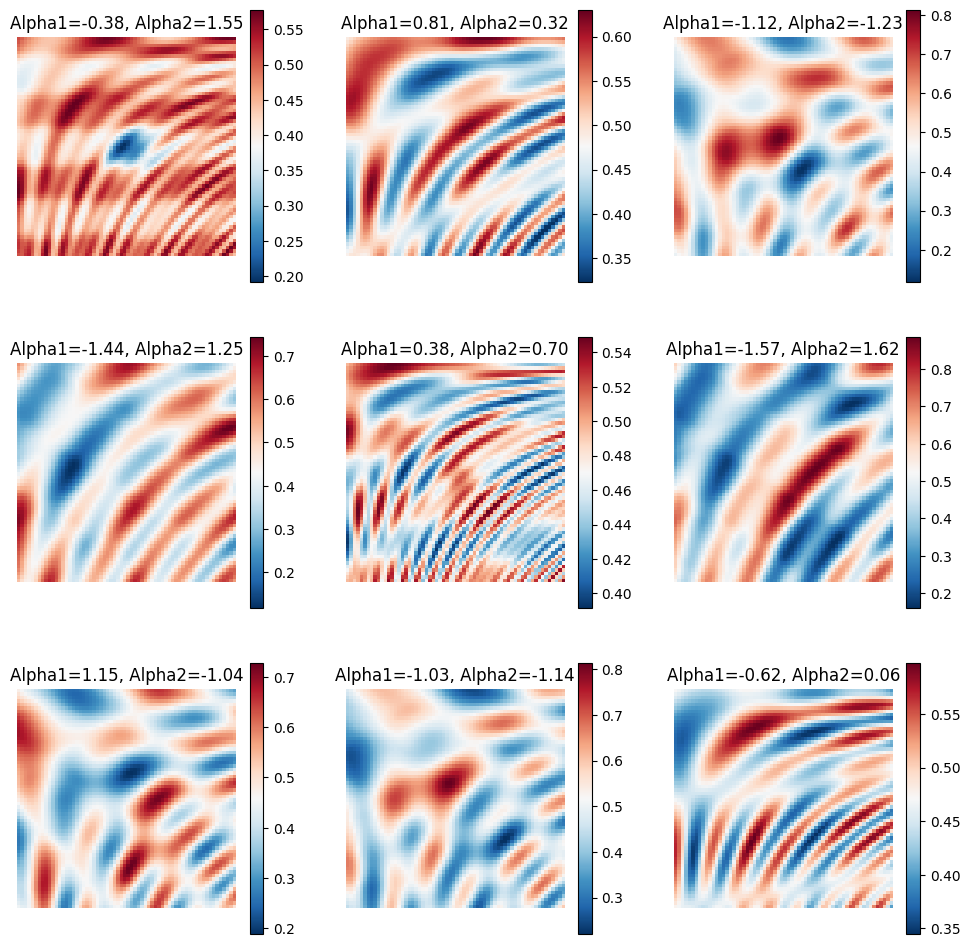

In [16]:
inputs_to_plot = test_parameters[:num_images]
real_values_to_plot = test_data[:num_images]
plot_images_grid(
    predictions[:num_images],
    inputs_to_plot,
)

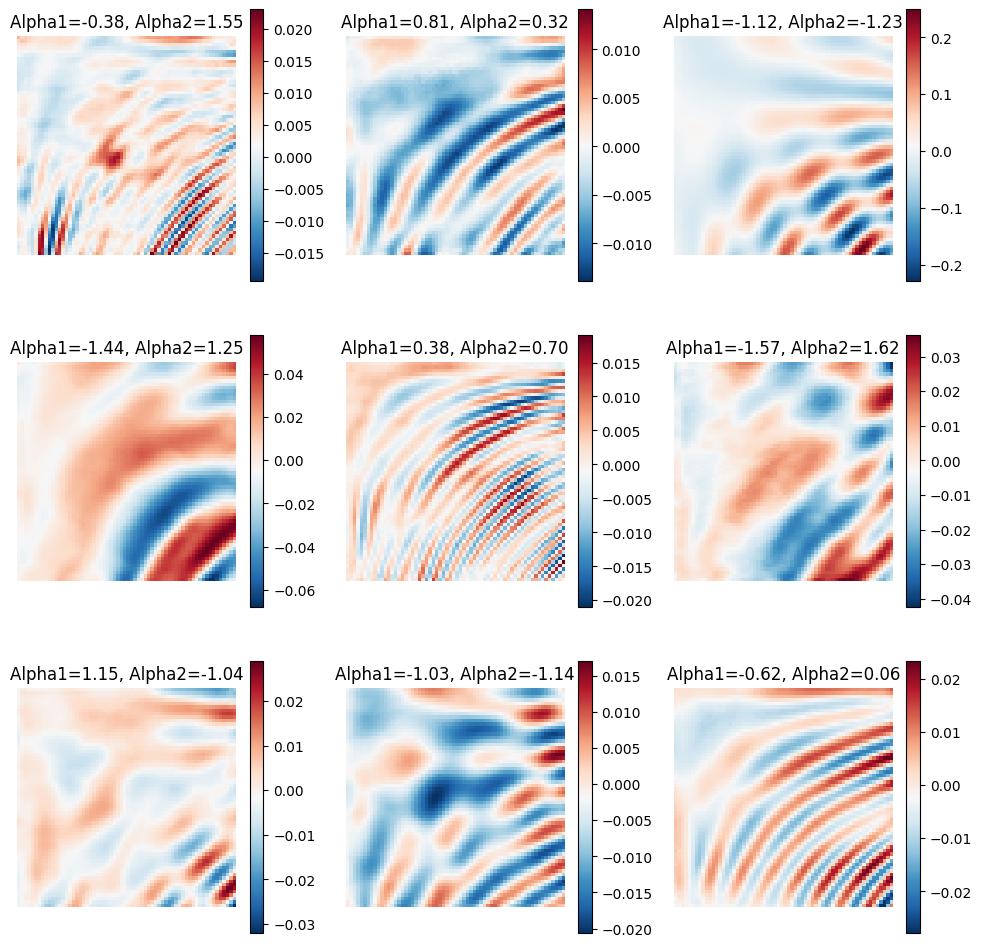

In [18]:
plot_images_grid(
    real_values_to_plot - predictions[:num_images].numpy(),
    inputs_to_plot,
)

In [14]:
data = np.load("../data/non_linear_eq/non_linear_train_solutions.npy")
# at the moment the model expects inputs in [0, 1], like grayscale images 
data_min, data_max = data.min(), data.max()
data = (data - data_min) / (data_max - data_min)  # scale to [0, 1]
data = data[:, np.newaxis, :, :]  # add channel dimension   
parameters = np.load("../data/non_linear_eq/non_linear_train_parameters.npy")
# normalize parameters to [0, 1]
parameters_mean, parameters_std = parameters.mean(axis=0), parameters.std(axis=0)
parameters = (parameters - parameters_mean) / (parameters_std)

# load test data
test_data = np.load("../data/non_linear_eq/non_linear_extrapolate_solutions.npy")
test_data = (test_data - data_min) / (data_max - data_min) 
# test_data = test_data[:, np.newaxis, :, :]
test_parameters = np.load("../data/non_linear_eq/non_linear_extrapolate_parameters.npy")
# test_parameters = (test_parameters - parameters_mean) / (parameters_std)

In [15]:
predictions = torch.load("../results/non_linear_eq_big_128_bs/extrapolation_predictions.pt")
predictions = predictions.view(-1, 64, 64).numpy()

/tmp/ipykernel_662931/517343730.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  predictions = torch.load("../results/non_linear_eq_big_128_bs/extrapolation_predictions.p

In [16]:
maes = np.abs(test_data - predictions).mean(axis=(1, 2))
maes.shape

(757,)

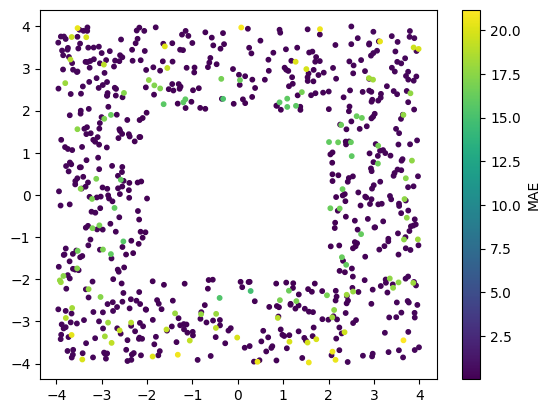

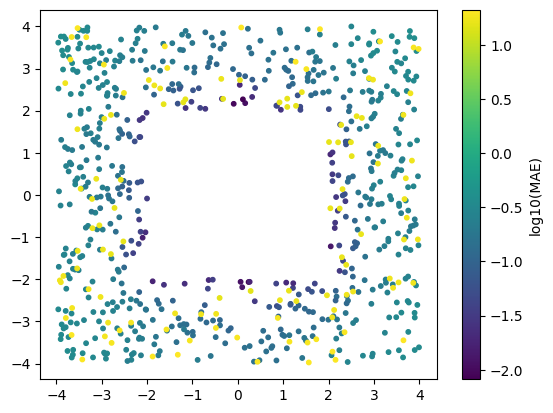

In [24]:
sc = plt.scatter(test_parameters[:, 0], test_parameters[:, 1], s=10, c=maes)
plt.colorbar(sc, label="MAE")
plt.show()

plt.figure()
sc = plt.scatter(test_parameters[:, 0], test_parameters[:, 1], s=10, c=np.log10(maes + 1e-10))
plt.colorbar(sc, label="log10(MAE)")
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have your test_parameters and maes arrays
# test_parameters = your_parameter_array
# maes = your_mae_values

# Option 1: Use a better colormap with improved contrast
plt.figure(figsize=(10, 8))
sc = plt.scatter(test_parameters[:, 0], test_parameters[:, 1], 
                s=15, c=maes, cmap='plasma', alpha=0.7)
plt.colorbar(sc, label="MAE")
plt.xlabel("Parameter 1")
plt.ylabel("Parameter 2")
plt.title("Parameter Space with MAE (Plasma Colormap)")
plt.grid(True, alpha=0.3)
plt.show()

# Option 2: Use log scale for color mapping (if MAE values span wide range)
plt.figure(figsize=(10, 8))
# Add small epsilon to avoid log(0) if you have zero values
maes_log = np.log10(maes + 1e-10)
sc = plt.scatter(test_parameters[:, 0], test_parameters[:, 1], 
                s=15, c=maes_log, cmap='viridis', alpha=0.8)
plt.colorbar(sc, label="log₁₀(MAE)")
plt.xlabel("Parameter 1")
plt.ylabel("Parameter 2")
plt.title("Parameter Space with log(MAE)")
plt.grid(True, alpha=0.3)
plt.show()

# Option 3: Use percentile-based color scaling
plt.figure(figsize=(10, 8))
# Clip extreme values to better show the bulk of the data
vmin, vmax = np.percentile(maes, [5, 95])
sc = plt.scatter(test_parameters[:, 0], test_parameters[:, 1], 
                s=15, c=maes, cmap='RdYlBu_r', 
                vmin=vmin, vmax=vmax, alpha=0.8)
plt.colorbar(sc, label="MAE", extend='both')
plt.xlabel("Parameter 1")
plt.ylabel("Parameter 2")
plt.title("Parameter Space with MAE (5th-95th percentile range)")
plt.grid(True, alpha=0.3)
plt.show()

# Option 4: Variable point sizes based on MAE + color
plt.figure(figsize=(10, 8))
# Normalize sizes (smaller MAE = larger points to highlight good regions)
sizes = 50 * (1 - (maes - maes.min()) / (maes.max() - maes.min())) + 5
sc = plt.scatter(test_parameters[:, 0], test_parameters[:, 1], 
                s=sizes, c=maes, cmap='coolwarm', 
                alpha=0.6, edgecolors='black', linewidth=0.1)
plt.colorbar(sc, label="MAE")
plt.xlabel("Parameter 1")
plt.ylabel("Parameter 2")
plt.title("Parameter Space (Size ∝ 1/MAE, Color = MAE)")
plt.grid(True, alpha=0.3)
plt.show()

# Option 5: Hexbin plot for density + average MAE
plt.figure(figsize=(10, 8))
hb = plt.hexbin(test_parameters[:, 0], test_parameters[:, 1], 
               C=maes, reduce_C_function=np.mean, 
               gridsize=30, cmap='plasma', alpha=0.8)
plt.colorbar(hb, label="Average MAE")
plt.xlabel("Parameter 1")
plt.ylabel("Parameter 2")
plt.title("Parameter Space - Hexbin with Average MAE")
plt.show()

# Option 6: Contour plot overlay
plt.figure(figsize=(12, 5))

# Left: scatter plot
plt.subplot(1, 2, 1)
sc = plt.scatter(test_parameters[:, 0], test_parameters[:, 1], 
                s=10, c=maes, cmap='plasma', alpha=0.7)
plt.colorbar(sc, label="MAE")
plt.xlabel("Parameter 1")
plt.ylabel("Parameter 2")
plt.title("Scatter Plot")
plt.grid(True, alpha=0.3)

# Right: scatter + contour
plt.subplot(1, 2, 2)
# Create a grid for interpolation
from scipy.interpolate import griddata
xi = np.linspace(test_parameters[:, 0].min(), test_parameters[:, 0].max(), 100)
yi = np.linspace(test_parameters[:, 1].min(), test_parameters[:, 1].max(), 100)
Xi, Yi = np.meshgrid(xi, yi)
Zi = griddata((test_parameters[:, 0], test_parameters[:, 1]), maes, 
              (Xi, Yi), method='cubic', fill_value=maes.mean())

# Plot contours
contour = plt.contourf(Xi, Yi, Zi, levels=20, cmap='plasma', alpha=0.6)
plt.colorbar(contour, label="MAE")

# Overlay scatter points
plt.scatter(test_parameters[:, 0], test_parameters[:, 1], 
           s=5, c='white', alpha=0.8, edgecolors='black', linewidth=0.1)
plt.xlabel("Parameter 1")
plt.ylabel("Parameter 2")
plt.title("Contour Plot with Data Points")

plt.tight_layout()
plt.show()

# Vae 

In [ ]:
import torch
import matplotlib.pyplot as plt
from diffusers import AutoencoderKL
import numpy as np

# ------------------
# Load trained VAE
# ------------------
vae = AutoencoderKL.from_pretrained("../vae_ldm/epoch_19")  # or epoch_X dir
# vae = AutoencoderKL.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="vae")
vae.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae.to(device)

# ------------------
# Example input (reload a batch from your dataset)
# ------------------
import numpy as np

data = np.load("../data/non_linear_eq/train_high_resolution_solutions.npy")
data_min, data_max = data.min(), data.max()
data = (data - data_min) / (data_max - data_min)   # scale to [0,1]
data = data * 2.0 - 1.0                           # rescale to [-1,1]
data = data[:, np.newaxis, :, :]                  # add channel dim

# take a few samples
batch = torch.tensor(data[:4]).float().to(device)

# ------------------
# Inference
# ------------------
with torch.no_grad():
    # Encode -> latent distribution
    encode_out = vae.encode(batch)
    latent_dist = encode_out.latent_dist
    z = latent_dist.sample()  # you could also use latent_dist.mean

    # Decode -> reconstruction
    recon = vae.decode(z).sample

# move to CPU for plotting
orig = batch.cpu()
recon = recon.cpu()
z = z.cpu()




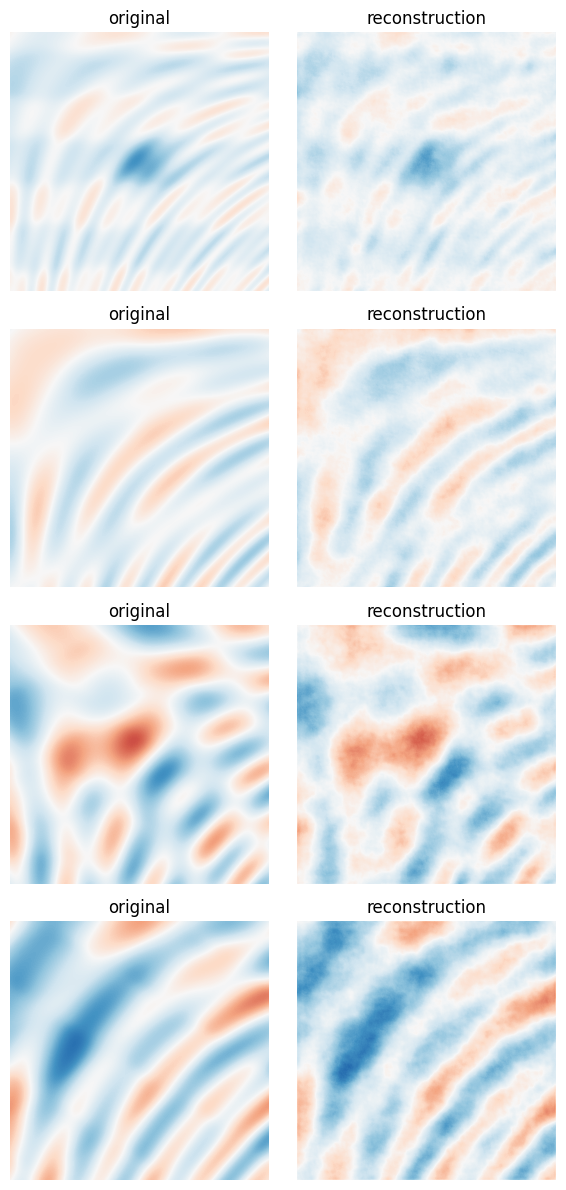

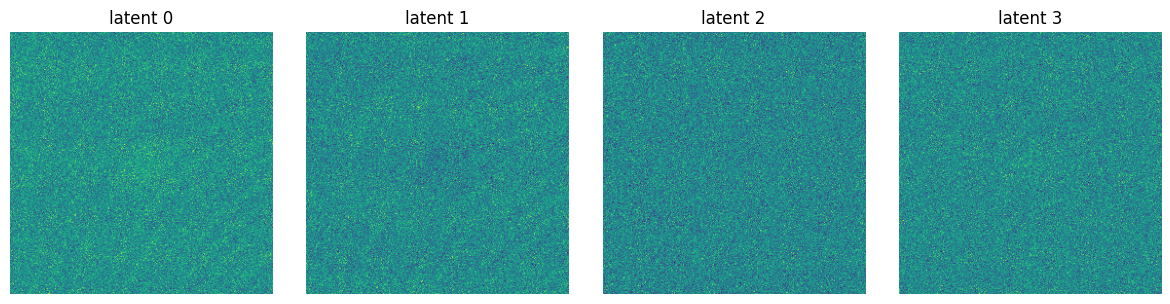

In [ ]:
# ------------------
# Plot originals and reconstructions
# ------------------
n = orig.shape[0]
fig, axes = plt.subplots(n, 2, figsize=(6, 3*n))
for i in range(n):
    axes[i,0].imshow(orig[i,0], cmap="RdBu_r", vmin=-1, vmax=1)
    axes[i,0].set_title("original")
    axes[i,0].axis("off")
    axes[i,1].imshow(recon[i,0], cmap="RdBu_r", vmin=-1, vmax=1)
    axes[i,1].set_title("reconstruction")
    axes[i,1].axis("off")
plt.tight_layout()
plt.show()

# ------------------
# Optional: visualize latent channels
# ------------------
fig, axes = plt.subplots(1, min(4, z.shape[1]), figsize=(12,3))
for i in range(min(4, z.shape[1])):
    axes[i].imshow(z[0,i], cmap="viridis")
    axes[i].set_title(f"latent {i}")
    axes[i].axis("off")
plt.tight_layout()
plt.show()

In [12]:
vae

AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down_blocks): ModuleList(
      (0): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0): ResnetBlock2D(
            (norm1): GroupNorm(8, 64, eps=1e-06, affine=True)
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(8, 64, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )
        )
        (downsamplers): ModuleList(
          (0): Downsample2D(
            (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2))
          )
        )
      )
      (1): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0): ResnetBlock2D(
            (norm1): GroupNorm(8, 64, eps=1e-06, affine=True)
            (conv1): Conv2d(64, 1

Using device: cuda
Loading data...
Original data shape: (1000, 1024, 1024)
Input batch shape: torch.Size([4, 1, 1024, 1024])

Testing: stability_mse (stabilityai/sd-vae-ft-mse)
Loading stabilityai/sd-vae-ft-mse...


config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Using input size: torch.Size([4, 1, 512, 512])
Latent shape: torch.Size([4, 4, 64, 64])


/tmp/ipykernel_662931/910558458.py:170: UserWarning: Using a target size (torch.Size([4, 3, 1024, 1024])) that is different to the input size (torch.Size([4, 1, 1024, 1024])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse_error = F.mse_loss(batch_1024, recon_1024)


✅ Success! MSE Error: 0.018240

Testing: stability_ema (stabilityai/sd-vae-ft-ema)
Loading stabilityai/sd-vae-ft-ema...


config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Using input size: torch.Size([4, 1, 512, 512])
Latent shape: torch.Size([4, 4, 64, 64])
✅ Success! MSE Error: 0.018468

Testing: ostris_vae (ostris/vae-kl-f8-d16)
Loading ostris/vae-kl-f8-d16...


config.json:   0%|          | 0.00/729 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

Using input size: torch.Size([4, 1, 512, 512])
Latent shape: torch.Size([4, 16, 64, 64])
✅ Success! MSE Error: 0.017392

Testing: tiny_vae (madebyollin/taesd)
Loading madebyollin/taesd...


config.json:   0%|          | 0.00/597 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/9.79M [00:00<?, ?B/s]

❌ Failed: 'EncoderTiny' object has no attribute 'conv_in'

Testing: sdxl_vae (stabilityai/sdxl-vae)
Loading stabilityai/sdxl-vae...


config.json:   0%|          | 0.00/607 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Using input size: torch.Size([4, 1, 1024, 1024])
Latent shape: torch.Size([4, 4, 128, 128])
✅ Success! MSE Error: 0.010166

CREATING VISUALIZATIONS


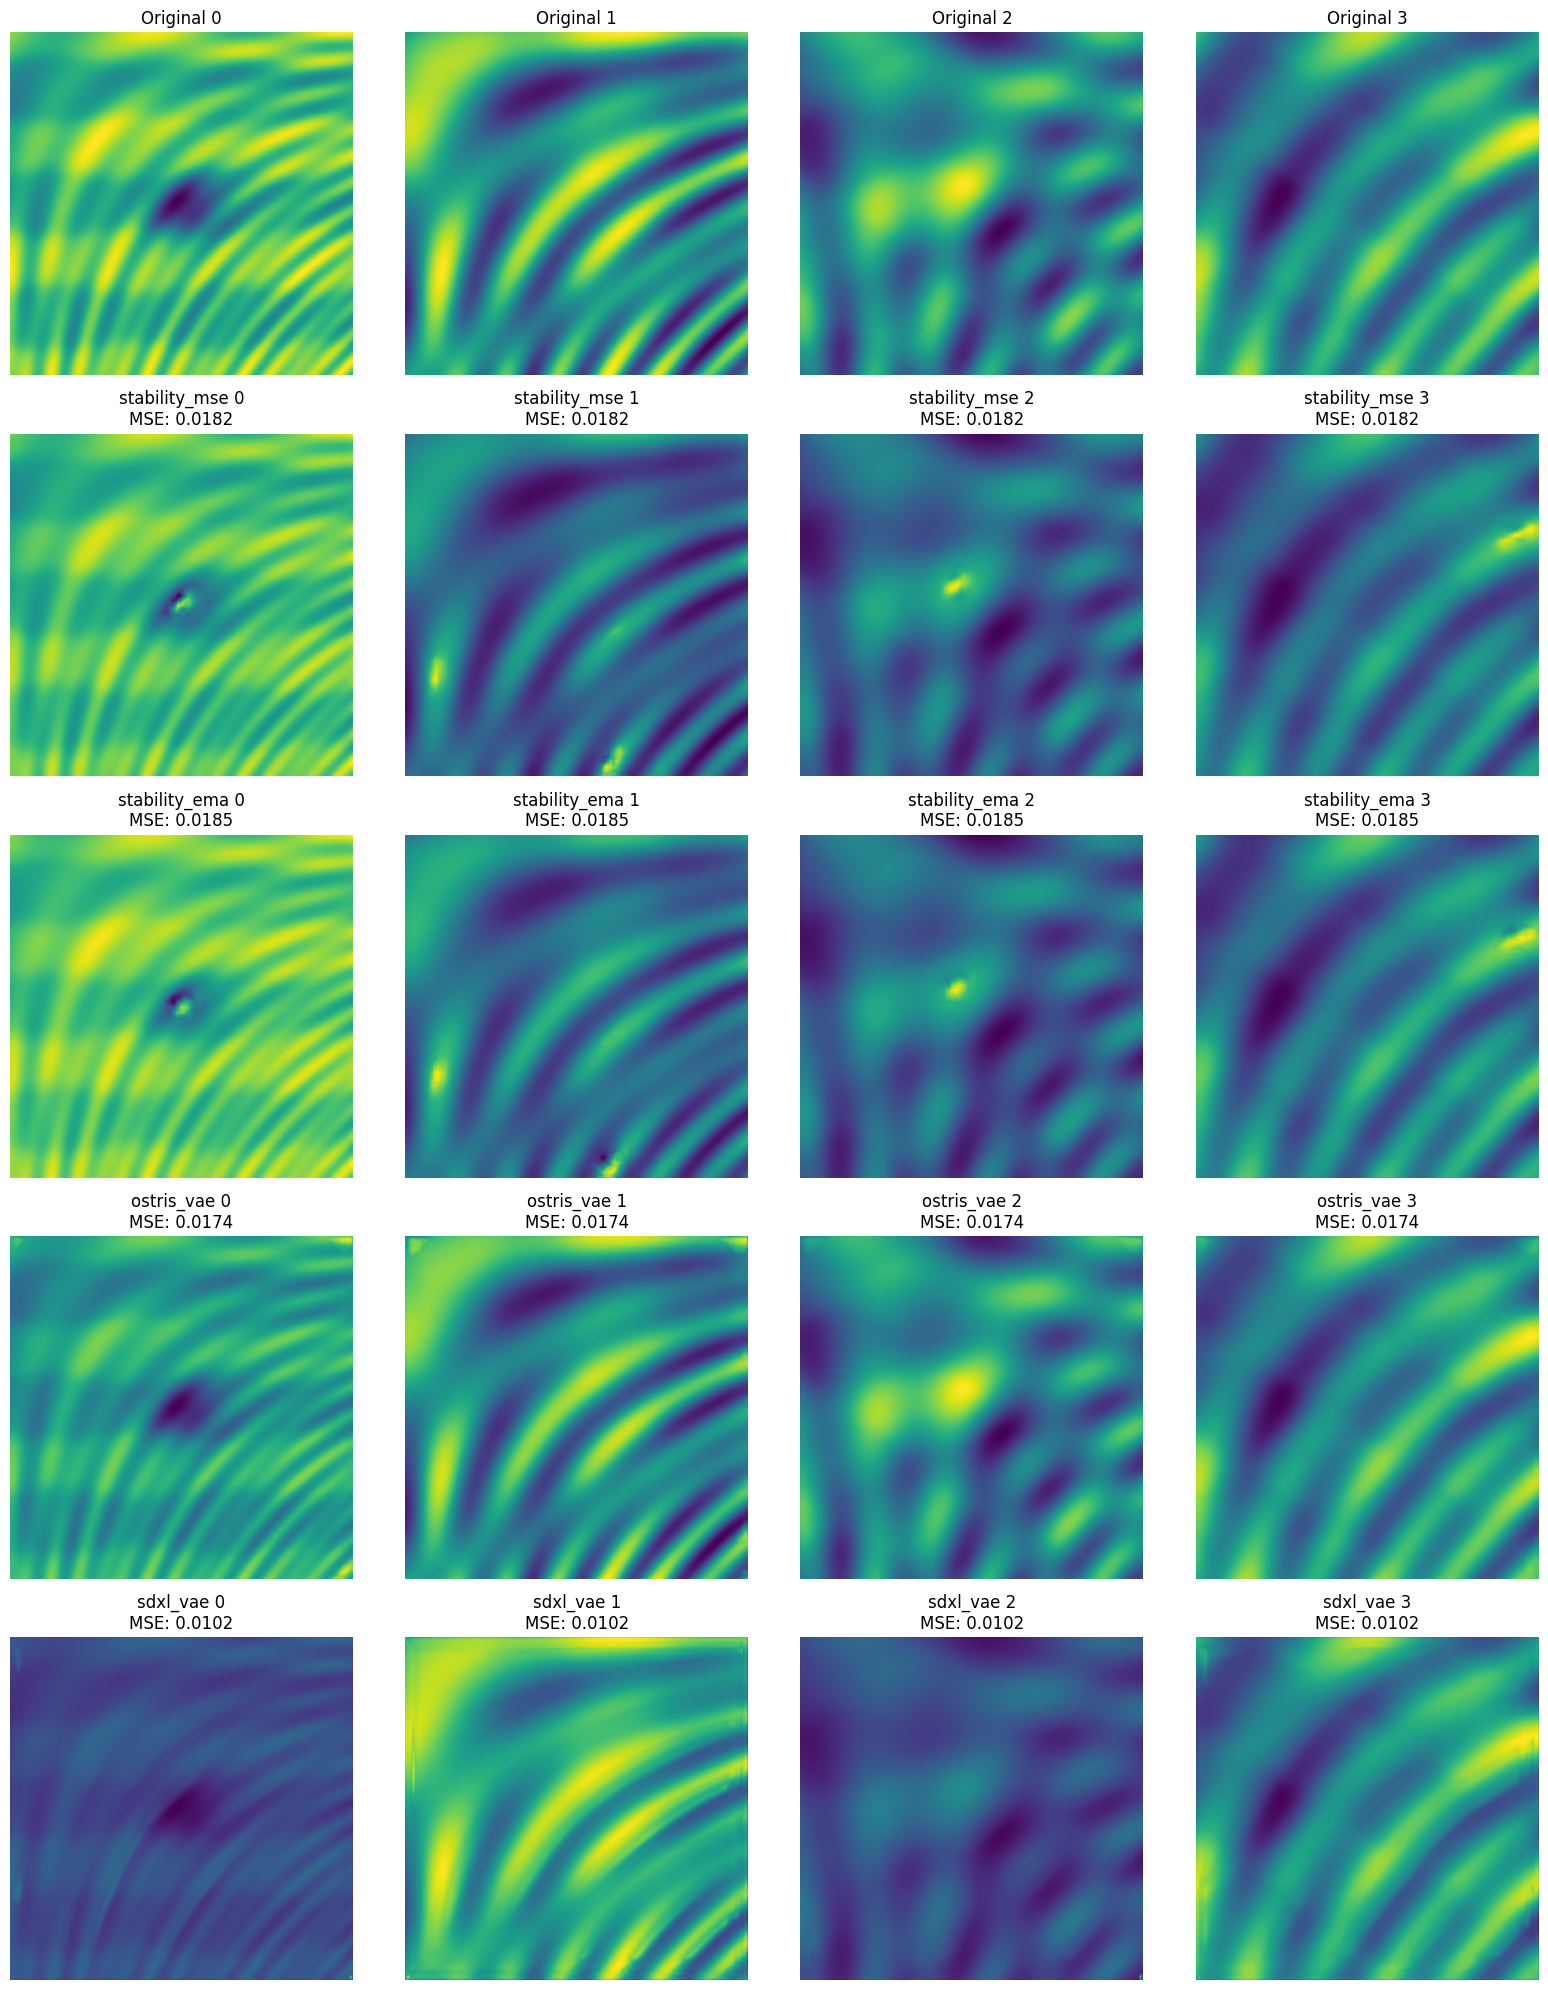


SUMMARY
✅ Successful VAEs:
  stability_mse: MSE = 0.018240 (stabilityai/sd-vae-ft-mse)
  stability_ema: MSE = 0.018468 (stabilityai/sd-vae-ft-ema)
  ostris_vae: MSE = 0.017392 (ostris/vae-kl-f8-d16)
  sdxl_vae: MSE = 0.010166 (stabilityai/sdxl-vae)

❌ Failed VAEs:
  tiny_vae: 'EncoderTiny' object has no attribute 'conv_in'

🏆 Best performing VAE: sdxl_vae (MSE: 0.010166)
   Model path: stabilityai/sdxl-vae

📋 Code to use the best VAE:

# Load the best performing VAE for your use case:
from diffusers import AutoencoderKL
vae = load_and_modify_vae("stabilityai/sdxl-vae", device)

# Use it for inference:
with torch.no_grad():
    batch_resized = resize_for_vae(your_batch, 512)  # or 1024 for SDXL
    encode_out = vae.encode(batch_resized)
    z = encode_out.latent_dist.sample() * vae.config.scaling_factor
    recon = vae.decode(z / vae.config.scaling_factor).sample



'\nIf the above doesn\'t work well, here are some other options:\n\n1. Medical Imaging Models (may need different loading):\n   - "microsoft/DiT-XL-2-256" (though this is for generation)\n   - Look for models tagged with "medical", "grayscale", "single-channel"\n\n2. Convert RGB pretrained to grayscale:\n   - The approach above should work with most VAEs\n   - "stabilityai/sd-vae-ft-mse" is often the most robust\n\n3. Domain-specific models:\n   - Search HuggingFace for models in your specific domain\n   - Look for "autoencoder", "vae", "latent" tags\n\n4. Train your own:\n   - Use the architecture from successful models above\n   - Fine-tune on your specific data\n\nThe code above tests multiple pretrained options and shows you \nwhich works best for your specific 1024x1024 single-channel data.\n'

In [28]:
import torch
import matplotlib.pyplot as plt
from diffusers import AutoencoderKL
import numpy as np
import torch.nn.functional as F

# ===================================================================
# AVAILABLE PRETRAINED SINGLE-CHANNEL OPTIONS ON HUGGING FACE
# ===================================================================

# Option 1: Tiny AutoEncoder (can be modified for single channel)
from diffusers import AutoencoderTiny

# Option 2: Custom models that might work with modification
PRETRAINED_VAES = {
    "stability_mse": "stabilityai/sd-vae-ft-mse",
    "stability_ema": "stabilityai/sd-vae-ft-ema", 
    "ostris_vae": "ostris/vae-kl-f8-d16",  # Alternative VAE
    "tiny_vae": "madebyollin/taesd",  # Tiny AutoEncoder
    "sdxl_vae": "stabilityai/sdxl-vae",
}

def load_and_modify_vae(model_name, device):
    """
    Load a pretrained VAE and modify it for single-channel input
    """
    print(f"Loading {model_name}...")
    
    if "taesd" in model_name or "tiny" in model_name.lower():
        # Special handling for Tiny AutoEncoder
        try:
            vae = AutoencoderTiny.from_pretrained(model_name)
        except:
            print(f"Failed to load {model_name} as AutoencoderTiny, trying AutoencoderKL...")
            vae = AutoencoderKL.from_pretrained(model_name)
    else:
        vae = AutoencoderKL.from_pretrained(model_name)
    
    # Modify the first convolution layer for single channel input
    original_conv = vae.encoder.conv_in
    
    # Create new conv layer with 1 input channel
    new_conv = torch.nn.Conv2d(
        in_channels=1,
        out_channels=original_conv.out_channels,
        kernel_size=original_conv.kernel_size,
        stride=original_conv.stride,
        padding=original_conv.padding,
        bias=original_conv.bias is not None
    )
    
    # Initialize by averaging RGB weights to grayscale
    with torch.no_grad():
        new_conv.weight = torch.nn.Parameter(
            original_conv.weight.mean(dim=1, keepdim=True)
        )
        if original_conv.bias is not None:
            new_conv.bias = torch.nn.Parameter(original_conv.bias.clone())
    
    # Replace the conv layer
    vae.encoder.conv_in = new_conv
    vae.eval()
    vae.to(device)
    
    return vae

def resize_for_vae(batch, target_size):
    """
    Resize batch to target size for VAE compatibility
    """
    if batch.shape[-1] != target_size:
        batch = F.interpolate(
            batch, 
            size=(target_size, target_size), 
            mode='bilinear', 
            align_corners=False
        )
    return batch

def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Load your data
    print("Loading data...")
    data = np.load("../data/non_linear_eq/train_high_resolution_solutions.npy")
    print(f"Original data shape: {data.shape}")
    
    # Normalize to [-1, 1]
    data_min, data_max = data.min(), data.max()
    data = (data - data_min) / (data_max - data_min)
    data = data * 2.0 - 1.0
    
    # Ensure proper shape (N, 1, H, W)
    if len(data.shape) == 3:
        data = data[:, np.newaxis, :, :]
    
    batch_1024 = torch.tensor(data[:4]).float().to(device)
    print(f"Input batch shape: {batch_1024.shape}")
    
    # Test different pretrained VAEs
    results = {}
    
    for vae_name, model_path in PRETRAINED_VAES.items():
        print(f"\n{'='*50}")
        print(f"Testing: {vae_name} ({model_path})")
        print('='*50)
        
        try:
            # Load and modify VAE
            vae = load_and_modify_vae(model_path, device)
            
            # Determine best input size for this VAE
            if "tiny" in vae_name.lower() or "taesd" in model_path:
                input_size = 512  # Tiny AE works better with 512
            elif "sdxl" in vae_name.lower():
                input_size = 1024  # SDXL can handle larger
            else:
                input_size = 512  # Standard SD VAEs prefer 512
            
            # Resize input if needed
            batch_resized = resize_for_vae(batch_1024, input_size)
            print(f"Using input size: {batch_resized.shape}")
            
            with torch.no_grad():
                # Encode
                encode_out = vae.encode(batch_resized)
                
                # Handle different VAE types
                if hasattr(encode_out, 'latent_dist'):
                    # Standard AutoencoderKL
                    latent_dist = encode_out.latent_dist
                    z = latent_dist.sample()
                    if hasattr(vae.config, 'scaling_factor'):
                        z = z * vae.config.scaling_factor
                elif hasattr(encode_out, 'latents'):
                    # Some VAEs return latents directly
                    z = encode_out.latents
                else:
                    # Direct tensor output
                    z = encode_out
                
                print(f"Latent shape: {z.shape}")
                
                # Decode
                if hasattr(vae.config, 'scaling_factor') and hasattr(encode_out, 'latent_dist'):
                    z_scaled = z / vae.config.scaling_factor
                    decode_out = vae.decode(z_scaled)
                else:
                    decode_out = vae.decode(z)
                
                # Handle different decode output types
                if hasattr(decode_out, 'sample'):
                    recon = decode_out.sample
                else:
                    recon = decode_out
                
                # Resize back to 1024 if needed
                if recon.shape[-1] != 1024:
                    recon_1024 = F.interpolate(
                        recon, 
                        size=(1024, 1024), 
                        mode='bilinear', 
                        align_corners=False
                    )
                else:
                    recon_1024 = recon
                
                # Calculate reconstruction error
                mse_error = F.mse_loss(batch_1024, recon_1024)
                
                # Store results
                results[vae_name] = {
                    'reconstruction': recon_1024.cpu(),
                    'latents': z.cpu(),
                    'mse_error': mse_error.item(),
                    'model_path': model_path,
                    'success': True
                }
                
                print(f"✅ Success! MSE Error: {mse_error:.6f}")
                
        except Exception as e:
            print(f"❌ Failed: {str(e)}")
            results[vae_name] = {
                'success': False,
                'error': str(e),
                'model_path': model_path
            }
    
    # ===== VISUALIZATION =====
    print(f"\n{'='*50}")
    print("CREATING VISUALIZATIONS")
    print('='*50)
    
    successful_results = {k: v for k, v in results.items() if v['success']}
    
    if not successful_results:
        print("❌ No VAEs worked successfully!")
        return
    
    n_models = len(successful_results)
    fig, axes = plt.subplots(n_models + 1, 4, figsize=(16, 4 * (n_models + 1)))
    
    if n_models == 0:
        axes = axes.reshape(1, -1)
    
    # Plot original images
    for i in range(4):
        if n_models > 0:
            axes[0, i].imshow(batch_1024[i, 0].cpu().numpy(), cmap='viridis')
            axes[0, i].set_title(f'Original {i}')
            axes[0, i].axis('off')
        else:
            axes[i].imshow(batch_1024[i, 0].cpu().numpy(), cmap='viridis')
            axes[i].set_title(f'Original {i}')
            axes[i].axis('off')
    
    # Plot reconstructions
    for row, (vae_name, result) in enumerate(successful_results.items()):
        for i in range(4):
            if n_models > 0:
                axes[row + 1, i].imshow(result['reconstruction'][i, 0].numpy(), cmap='viridis')
                axes[row + 1, i].set_title(f'{vae_name} {i}\nMSE: {result["mse_error"]:.4f}')
                axes[row + 1, i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # ===== SUMMARY =====
    print(f"\n{'='*50}")
    print("SUMMARY")
    print('='*50)
    
    print("✅ Successful VAEs:")
    for vae_name, result in successful_results.items():
        print(f"  {vae_name}: MSE = {result['mse_error']:.6f} ({result['model_path']})")
    
    print("\n❌ Failed VAEs:")
    for vae_name, result in results.items():
        if not result['success']:
            print(f"  {vae_name}: {result['error']}")
    
    if successful_results:
        best_vae = min(successful_results.items(), key=lambda x: x[1]['mse_error'])
        print(f"\n🏆 Best performing VAE: {best_vae[0]} (MSE: {best_vae[1]['mse_error']:.6f})")
        print(f"   Model path: {best_vae[1]['model_path']}")
        
        # Save best reconstruction code
        print(f"\n📋 Code to use the best VAE:")
        print(f"""
# Load the best performing VAE for your use case:
from diffusers import AutoencoderKL
vae = load_and_modify_vae("{best_vae[1]['model_path']}", device)

# Use it for inference:
with torch.no_grad():
    batch_resized = resize_for_vae(your_batch, 512)  # or 1024 for SDXL
    encode_out = vae.encode(batch_resized)
    z = encode_out.latent_dist.sample() * vae.config.scaling_factor
    recon = vae.decode(z / vae.config.scaling_factor).sample
""")

# if __name__ == "__main__":
main()

# ===================================================================
# ALTERNATIVE: BEST SINGLE-CHANNEL MODELS TO TRY
# ===================================================================
"""
If the above doesn't work well, here are some other options:

1. Medical Imaging Models (may need different loading):
   - "microsoft/DiT-XL-2-256" (though this is for generation)
   - Look for models tagged with "medical", "grayscale", "single-channel"

2. Convert RGB pretrained to grayscale:
   - The approach above should work with most VAEs
   - "stabilityai/sd-vae-ft-mse" is often the most robust

3. Domain-specific models:
   - Search HuggingFace for models in your specific domain
   - Look for "autoencoder", "vae", "latent" tags

4. Train your own:
   - Use the architecture from successful models above
   - Fine-tune on your specific data

The code above tests multiple pretrained options and shows you 
which works best for your specific 1024x1024 single-channel data.
"""